# Gene x Noise interaction analysis

Using the recoding gene level dosage to do Gene x Noise interaction analysis

In [3]:
# Common variables Columbia's cluster
UKBB_PATH=$HOME/UKBiobank
UKBB_yale=$HOME/UKBiobank_Yale_transfer
USER_PATH=$HOME/working
container_lmm=$HOME/containers/lmm.sif
container_marp=$HOME/containers/marp.sif
container_annovar=$HOME/containers/gatk4-annovar.sif
hearing_pheno_path=$UKBB_PATH/phenotype_files/hearing_impairment
tpl_file=$USER_PATH/bioworkflows/admin/csg.yml
formatFile_fastgwa=$USER_PATH/UKBB_GWAS_dev/data/fastGWA_template.yml
formatFile_bolt=$USER_PATH/UKBB_GWAS_dev/data/boltlmm_template.yml
formatFile_saige=$USER_PATH/UKBB_GWAS_dev/data/saige_template.yml
formatFile_regenie=$USER_PATH/UKBB_GWAS_dev/data/regenie_template.yml
# Workflows
lmm_sos=$USER_PATH/bioworkflows/GWAS/LMM.ipynb
anno_sos=$USER_PATH/bioworkflows/variant-annotation/annovar.ipynb
clumping_sos=$USER_PATH/bioworkflows/GWAS/LD_Clumping.ipynb
extract_sos=$USER_PATH/bioworkflows/GWAS/Region_Extraction.ipynb
snptogene_sos=$USER_PATH/UKBB_GWAS_dev/workflow/snptogene.ipynb

# LMM directories for array data data
lmm_imp_dir_fastgwa=$UKBB_PATH/results/FastGWA_results/results_array_data
lmm_imp_dir_bolt=$UKBB_PATH/results/BOLTLMM_results/results_array_data
lmm_imp_dir_saige=$UKBB_PATH/results/SAIGE_results/results_array_data
lmm_imp_dir_regenie=$UKBB_PATH/results/REGENIE_results/results_array_data

# LMM directories for exome data
lmm_exome_dir_fastgwa=$UKBB_PATH/results/FastGWA_results/results_array_data
lmm_exome_dir_bolt=$UKBB_PATH/results/BOLTLMM_results/results_array_data
lmm_exome_dir_saige=$UKBB_PATH/results/SAIGE_results/results_array_data
lmm_exome_dir_regenie=$UKBB_PATH/results/REGENIE_results/results_array_data
### Specific to REGENIE
bsize=1000
lowmem=~/project/guangyou/interaction/scratch60/
lowmem_dir=~/project/guangyou/interaction/scratch60/predictions
trait=bt
minMAC=4
maf_filter=0
geno_filter=0
hwe_filter=0
mind_filter=0
reverse_log_p=True
numThreads=2

In [2]:
## All filters set to 0 because the version of the bfile has already been QC'ed previously and there is not need to do it here
maf_filter=0
geno_filter=0
hwe_filter=0
mind_filter=0
lmm_dir_regenie=/home/gl2776/project/guangyou/epistasis/20220307_regenie_interaction_GenexNoise/20220307_f3393
lmm_sbatch_regenie=$lmm_dir_regenie/f3393_noise_interaction-regenie_$(date +"%Y-%m-%d").sbatch
#Use the phenotype file for the 500K individuals
phenoFile=~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/phenotypes/021522_UKBB_Hearing_aid_f3393_expandedwhite_15601cases_237318ctrl_500k_PC1_PC2_noise
phenoCol=f3393
covarCol=sex
qCovarCol="age PC1 PC2"
#Use the original bed files that passed QC using Megan's parameters geno=0.01, mind=0.1, maf=0.01, hwe=5e-08
bfile=$UKBB_PATH/genotype_files_processed/090221_sample_variant_qc_final_callrate90/cache/UKB_genotypedatadownloaded083019.090221_sample_variant_qc_final_callrate90.filtered.extracted.bed
# Use the gene bfile here for the association
genoFile="~/project/guangyou/epistasis/chr1/ukb23155_c1_b0_v1.filtered.gene.bed"
for i in {2..22}
do
genoFile=`echo "${genoFile} ~/project/guangyou/epistasis/chr${i}/ukb23155_c${i}_b0_v1.filtered.gene.bed"`
done
## After doing the annotation you can create the annotatted manhatan plot
lmm_job_size=20
bgenMinMAF=0.001
bgenMinINFO=0.8
regenie_sos=~/working/interaction/newv/Regenie_interaction_GxE.ipynb
regenieFile=/mnt/mfs/statgen/guangyou/containers/regenie.v.2.3
lowmem_dir=$lmm_dir_regenie/scratch60/
covariates="f3393_f4825_1 f3393_f4836_1 f3393_f4825_f4836_1 f3393_f4825_2 f3393_f4836_2 f3393_f4825_f4836_2"
# If --annotate then it will add the label to the plot otherwise --no-annotate

lmm_args="""regenie
    --cwd $lmm_dir_regenie 
    --bfile $bfile 
    --genoFile $genoFile
    --phenoFile $phenoFile 
    --formatFile $formatFile_regenie 
    --regenieFile $regenieFile
    --sampleFile $sampleFile
    --phenoCol $phenoCol
    --covarCol $covarCol  
    --qCovarCol $qCovarCol
    --bsize $bsize
    --lowmem_dir $lowmem_dir
    --trait $trait
    --covariates $covariates
    --bgenMinMAF $bgenMinMAF 
    --bgenMinINFO $bgenMinINFO
    --maf_filter $maf_filter
    --geno_filter $geno_filter
    --hwe_filter $hwe_filter
    --mind_filter $mind_filter
    --minMAC $minMAC
    --job_size $lmm_job_size
    --container_lmm $container_lmm
    --container_marp $container_marp
"""

sos run ~/working/UKBB_GWAS_dev/admin/Get_Job_Script.ipynb csg\
    --template-file $tpl_file \
    --workflow-file $regenie_sos \
    --to-script $lmm_sbatch_regenie \
    --args "$lmm_args" 

INFO: Running csg: Configuration for Columbia csg partition cluster
INFO: csg is completed.
INFO: csg output:   /home/gl2776/project/guangyou/epistasis/20220307_regenie_interaction_GenexNoise/20220307_f3393/f3393_noise_interaction-regenie_2022-03-07.sbatch
INFO: Workflow csg (ID=w6b6875d2b67ec92f) is executed successfully with 1 completed step.


## Phenotype exploration 

In [23]:
import pandas as pd
file = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/phenotypes/021522_UKBB_Hearing_aid_f3393_expandedwhite_15601cases_237318ctrl_500k_PC1_PC2_noise"
pheno = pd.read_csv(file,sep="\t",header=0)
pheno

,FID,IID,sex,f3393,age,PC1,PC2,f3393_f4825_1,f3393_f4836_1,f3393_f4825_f4836_1,f3393_f4825_2,f3393_f4836_2,f3393_f4825_f4836_2
0,1000112,1000112,0,1,68,0.011931,0.031198,0.0,0.0,0.0,0.0,0.0,0.0
1,1001067,1001067,0,1,50,0.004472,0.002904,0.0,0.0,0.0,0.0,0.0,0.0
2,1001384,1001384,1,1,61,0.002001,-0.001850,1.0,1.0,1.0,1.0,1.0,1.0
3,1001459,1001459,0,1,64,0.010770,0.022391,NaN,NaN,NaN,NaN,NaN,NaN
4,1002548,1002548,0,1,62,0.000226,-0.014383,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
252914,6025363,6025363,0,0,64,0.004982,0.006218,NaN,NaN,NaN,NaN,NaN,NaN
252915,6025409,6025409,1,0,66,0.002693,-0.003802,0.0,0.0,0.0,0.0,0.0,0.0
252916,6025411,6025411,1,0,49,0.014998,0.007031,0.0,0.0,0.0,0.0,0.0,0.0
252917,6025425,6025425,1,0,44,0.017568,0.020817,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
pheno["f3393_f4825_1"].value_counts()

0.0    80521
1.0    12678
Name: f3393_f4825_1, dtype: int64

In [25]:
pheno["f3393_f4836_1"].value_counts()

0.0    88213
1.0     6716
Name: f3393_f4836_1, dtype: int64

In [26]:
pheno["f3393_f4825_f4836_1"].value_counts()

0.0    74238
1.0    17461
Name: f3393_f4825_f4836_1, dtype: int64

In [27]:
pheno["f3393_f4825_2"].value_counts()

0.0    84963
1.0    12678
Name: f3393_f4825_2, dtype: int64

In [28]:
pheno["f3393_f4836_2"].value_counts()

0.0    90621
1.0     6716
Name: f3393_f4836_2, dtype: int64

In [29]:
pheno["f3393_f4825_f4836_2"].value_counts()

0.0    79588
1.0    17461
Name: f3393_f4825_f4836_2, dtype: int64

In [60]:
file = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/phenotypes/021522_UKBB_Hearing_difficulty_f2247_expandedwhite_110453cases_237318ctrl_500k_PC1_PC2_noise"
pheno = pd.read_csv(file,sep="\t",header=0)
pheno

,FID,IID,sex,f2247,age,PC1,PC2,f2247_f4825_1,f2247_f4836_1,f2247_f4825_f4836_1,f2247_f4825_2,f2247_f4836_2,f2247_f4825_f4836_2
0,1000022,1000022,0,1,53,-0.000623,0.016518,NaN,NaN,NaN,NaN,NaN,NaN
1,1000090,1000090,1,1,64,0.025180,-0.040743,0.0,0.0,0.0,0.0,0.0,0.0
2,1000112,1000112,0,1,68,0.011810,-0.031017,0.0,0.0,0.0,0.0,0.0,0.0
3,1000170,1000170,1,1,51,-0.004734,0.007340,NaN,NaN,NaN,NaN,NaN,NaN
4,1000198,1000198,1,1,41,0.009936,-0.020225,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
347766,6025363,6025363,0,0,64,0.004748,-0.006517,NaN,NaN,NaN,NaN,NaN,NaN
347767,6025409,6025409,1,0,66,0.002788,0.003365,0.0,0.0,0.0,0.0,0.0,0.0
347768,6025411,6025411,1,0,49,0.015194,-0.006870,0.0,0.0,0.0,0.0,0.0,0.0
347769,6025425,6025425,1,0,44,0.017146,-0.020943,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
pheno["f2247_f4825_1"].value_counts()

0.0    105079
1.0     22229
Name: f2247_f4825_1, dtype: int64

In [62]:
pheno["f2247_f4836_1"].value_counts()

0.0    118602
1.0     11055
Name: f2247_f4836_1, dtype: int64

In [35]:
pheno["f2247_f4825_f4836_1"].value_counts()

0.0    95586
1.0    29618
Name: f2247_f4825_f4836_1, dtype: int64

In [37]:
pheno["f2247_f4825_2"].value_counts()

0.0    111640
1.0     22229
Name: f2247_f4825_2, dtype: int64

In [36]:
pheno["f2247_f4836_2"].value_counts()

0.0    122253
1.0     11055
Name: f2247_f4836_2, dtype: int64

In [38]:
pheno["f2247_f4825_f4836_2"].value_counts()

0.0    103331
1.0     29618
Name: f2247_f4825_f4836_2, dtype: int64

In [39]:
file = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/phenotypes/021522_UKBB_Hearing_noise_f2257_expandedwhite_161443cases_237318ctrl_500k_PC1_PC2_noise"
pheno = pd.read_csv(file,sep="\t",header=0)
pheno

,FID,IID,sex,f2257,age,PC1,PC2,f2257_f4825_1,f2257_f4836_1,f2257_f4825_f4836_1,f2257_f4825_2,f2257_f4836_2,f2257_f4825_f4836_2
0,1000022,1000022,0,1,53,-0.000579,0.016713,NaN,NaN,NaN,NaN,NaN,NaN
1,1000035,1000035,0,1,63,0.020675,-0.031937,NaN,NaN,NaN,NaN,NaN,NaN
2,1000046,1000046,1,1,73,0.009413,-0.007380,0.0,0.0,0.0,0.0,0.0,0.0
3,1000054,1000054,1,1,65,0.011344,-0.018714,NaN,NaN,NaN,NaN,NaN,NaN
4,1000105,1000105,1,1,54,0.001477,-0.002987,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
398756,6025363,6025363,0,0,64,0.004751,-0.006342,NaN,NaN,NaN,NaN,NaN,NaN
398757,6025409,6025409,1,0,66,0.002914,0.003327,0.0,0.0,0.0,0.0,0.0,0.0
398758,6025411,6025411,1,0,49,0.015197,-0.006847,0.0,0.0,0.0,0.0,0.0,0.0
398759,6025425,6025425,1,0,44,0.017224,-0.021020,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
pheno["f2257_f4825_1"].value_counts()

0.0    115472
1.0     24351
Name: f2257_f4825_1, dtype: int64

In [41]:
pheno["f2257_f4836_1"].value_counts()

0.0    130191
1.0     12249
Name: f2257_f4836_1, dtype: int64

In [42]:
pheno["f2257_f4825_f4836_1"].value_counts()

0.0    104783
1.0     32583
Name: f2257_f4825_f4836_1, dtype: int64

In [43]:
pheno["f2257_f4825_2"].value_counts()

0.0    122921
1.0     24351
Name: f2257_f4825_2, dtype: int64

In [44]:
pheno["f2257_f4836_2"].value_counts()

0.0    134355
1.0     12249
Name: f2257_f4836_2, dtype: int64

In [45]:
pheno["f2257_f4825_f4836_2"].value_counts()

0.0    113607
1.0     32583
Name: f2257_f4825_f4836_2, dtype: int64

In [46]:
file = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/phenotypes/021522_UKBB_Combined_f2247_f2257_expandedwhite_93258cases_237318ctrl_500k_PC1_PC2"
pheno = pd.read_csv(file,sep="\t",header=0)
pheno

,FID,IID,sex,f2247_f2257,age,PC1,PC2,f2247_f2257_f4825_1,f2247_f2257_f4836_1,f2247_f2257_f4825_f4836_1,f2247_f2257_f4825_2,f2247_f2257_f4836_2,f2247_f2257_f4825_f4836_2
0,1000022,1000022,0,1,53,-0.000797,-0.016455,NaN,NaN,NaN,NaN,NaN,NaN
1,1000112,1000112,0,1,68,0.011949,0.030800,0.0,0.0,0.0,0.0,0.0,0.0
2,1000170,1000170,1,1,51,-0.004747,-0.007280,NaN,NaN,NaN,NaN,NaN,NaN
3,1000198,1000198,1,1,41,0.010282,0.020193,NaN,NaN,NaN,NaN,NaN,NaN
4,1000203,1000203,1,1,49,0.011262,0.014688,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
330571,6025363,6025363,0,0,64,0.004765,0.006384,NaN,NaN,NaN,NaN,NaN,NaN
330572,6025409,6025409,1,0,66,0.002683,-0.003474,0.0,0.0,0.0,0.0,0.0,0.0
330573,6025411,6025411,1,0,49,0.015108,0.006723,0.0,0.0,0.0,0.0,0.0,0.0
330574,6025425,6025425,1,0,44,0.017489,0.020690,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
pheno["f2247_f2257_f4825_1"].value_counts()

0.0    98575
1.0    20382
Name: f2247_f2257_f4825_1, dtype: int64

In [51]:
pheno["f2247_f2257_f4836_1"].value_counts()

0.0    111021
1.0     10087
Name: f2247_f2257_f4836_1, dtype: int64

In [54]:
pheno["f2247_f2257_f4825_f4836_1"].value_counts()

0.0    89858
1.0    27142
Name: f2247_f2257_f4825_f4836_1, dtype: int64

In [55]:
pheno["f2247_f2257_f4825_2"].value_counts()

0.0    104616
1.0     20382
Name: f2247_f2257_f4825_2, dtype: int64

In [56]:
pheno["f2247_f2257_f4836_2"].value_counts()

0.0    114378
1.0     10087
Name: f2247_f2257_f4836_2, dtype: int64

In [58]:
pheno["f2247_f2257_f4825_f4836_2"].value_counts()

0.0    97008
1.0    27142
Name: f2247_f2257_f4825_f4836_2, dtype: int64

# Result analysis

In [2]:
ls /home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393/cache | head 

UKB_genotypedatadownloaded083019.090221_sample_variant_qc_final_callrate90.filtered.extracted.qc_pass.id
UKB_genotypedatadownloaded083019.090221_sample_variant_qc_final_callrate90.filtered.extracted.qc_pass.log
UKB_genotypedatadownloaded083019.090221_sample_variant_qc_final_callrate90.filtered.extracted.qc_pass.snplist
UKB_genotypedatadownloaded083019.090221_sample_variant_qc_final_callrate90.filtered.extracted.qc_pass.stderr
UKB_genotypedatadownloaded083019.090221_sample_variant_qc_final_callrate90.filtered.extracted.qc_pass.stdout
ukb_imp_chr10_v3.f3393_f4825_1_f3393.regenie.gz
ukb_imp_chr10_v3.f3393_f4825_1_f3393.regenie.stderr
ukb_imp_chr10_v3.f3393_f4825_1_f3393.regenie.stdout
ukb_imp_chr10_v3.f3393_f4825_1.log
ukb_imp_chr10_v3.f3393_f4825_2_f3393.regenie.gz
ls: write error: Broken pipe


In [4]:
ls /home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393/cache | grep .gz | wc -l

118


In [5]:
ls /home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393/cache | grep .gz | head -n 20

ukb_imp_chr10_v3.f3393_f4825_1_f3393.regenie.gz
ukb_imp_chr10_v3.f3393_f4825_2_f3393.regenie.gz
ukb_imp_chr10_v3.f3393_f4825_f4836_1_f3393.regenie.gz
ukb_imp_chr10_v3.f3393_f4825_f4836_2_f3393.regenie.gz
ukb_imp_chr10_v3.f3393_f4836_1_f3393.regenie.gz
ukb_imp_chr10_v3.f3393_f4836_2_f3393.regenie.gz
ukb_imp_chr11_v3.f3393_f4825_1_f3393.regenie.gz
ukb_imp_chr11_v3.f3393_f4825_2_f3393.regenie.gz
ukb_imp_chr11_v3.f3393_f4825_f4836_1_f3393.regenie.gz
ukb_imp_chr11_v3.f3393_f4825_f4836_2_f3393.regenie.gz
ukb_imp_chr11_v3.f3393_f4836_1_f3393.regenie.gz
ukb_imp_chr11_v3.f3393_f4836_2_f3393.regenie.gz
ukb_imp_chr12_v3.f3393_f4825_1_f3393.regenie.gz
ukb_imp_chr12_v3.f3393_f4825_2_f3393.regenie.gz
ukb_imp_chr12_v3.f3393_f4825_f4836_1_f3393.regenie.gz
ukb_imp_chr12_v3.f3393_f4825_f4836_2_f3393.regenie.gz
ukb_imp_chr12_v3.f3393_f4836_1_f3393.regenie.gz
ukb_imp_chr12_v3.f3393_f4836_2_f3393.regenie.gz
ukb_imp_chr13_v3.f3393_f4825_1_f3393.regenie.gz
ukb_imp_chr13_v3.f3393_f4825_2_f3393.regenie.gz
grep

In [7]:
ls /home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393/cache | grep f3393_f4825_1_f3393.regenie.gz | wc -l

22


In [2]:
ls /home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393/cache | grep f3393_f4836_1_f3393.regenie.gz | wc -l

22


In [3]:
ls /home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393/cache | grep f3393_f4825_f4836_1_f3393.regenie.gz | wc -l

22


In [4]:
ls /home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393/cache | grep f3393_f4825_2_f3393.regenie.gz | wc -l

22


In [5]:
ls /home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393/cache | grep f3393_f4836_2_f3393.regenie.gz | wc -l

22


In [6]:
ls /home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393/cache | grep f3393_f4825_f4836_2_f3393.regenie.gz | wc -l

22


In [13]:
import pandas as pd 
df = pd.read_csv("/home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393/cache/ukb_imp_chr1_v3.f3393_f4825_2_f3393.regenie.gz",compression="gzip",header=0,sep=" ")
df

,CHROM,GENPOS,ID,ALLELE0,ALLELE1,A1FREQ,INFO,N,TEST,BETA,SE,CHISQ,LOG10P,EXTRA
0,1,13259,rs562993331,A,G,0.999743,0.844667,97641,ADD-CONDTL,-1.092790,0.452605,5.009340,1.598410,NaN
1,1,13259,rs562993331,A,G,0.999743,0.844667,97641,ADD-INT_SNP,-1.242580,0.498009,6.225450,1.899880,NaN
2,1,13259,rs562993331,A,G,0.999743,0.844667,97641,ADD-INT_SNPxf3393_f4825_2,0.897739,1.124690,0.637145,0.371870,NaN
3,1,13259,rs562993331,A,G,0.999743,0.844667,97641,ADD-INT_2DF,NaN,NaN,6.342170,1.377180,NaN
4,1,17569,rs535086049,A,C,0.999977,0.900076,97641,ADD-CONDTL,1.230300,2.130400,0.333505,0.249027,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6563382,1,249230914,rs201152607,T,C,0.994079,0.821221,97641,ADD-INT_2DF,NaN,NaN,3.344280,0.726201,NaN
6563383,1,249231938,rs530153783,A,T,0.999962,0.811925,97641,ADD-CONDTL,1.041810,1.641700,0.402710,0.279268,NaN
6563384,1,249231938,rs530153783,A,T,0.999962,0.811925,97641,ADD-INT_SNP,2.971050,6.449540,0.212209,0.190412,NaN
6563385,1,249231938,rs530153783,A,T,0.999962,0.811925,97641,ADD-INT_SNPxf3393_f4825_2,-0.779850,29.027500,0.000722,0.009410,NaN


In [14]:
inter = df[df["TEST"].str.startswith("ADD-INT_SNPx")]
inter

,CHROM,GENPOS,ID,ALLELE0,ALLELE1,A1FREQ,INFO,N,TEST,BETA,SE,CHISQ,LOG10P,EXTRA
2,1,13259,rs562993331,A,G,0.999743,0.844667,97641,ADD-INT_SNPxf3393_f4825_2,0.897739,1.124690,0.637145,0.371870,NaN
6,1,17569,rs535086049,A,C,0.999977,0.900076,97641,ADD-INT_SNPxf3393_f4825_2,-42.623300,336.666000,0.016029,0.046118,NaN
10,1,17641,rs578081284,A,G,0.999153,0.864092,97641,ADD-INT_SNPxf3393_f4825_2,0.425144,0.936377,0.206144,0.187216,NaN
14,1,52144,rs190291950,A,T,0.999497,0.817637,97641,ADD-INT_SNPxf3393_f4825_2,0.848248,1.202550,0.497555,0.318238,NaN
18,1,57222,rs576081345,C,T,0.999414,0.839973,97641,ADD-INT_SNPxf3393_f4825_2,-0.549302,0.979596,0.314433,0.240353,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6563369,1,249230279,rs146821690,G,C,0.994111,0.826877,97641,ADD-INT_SNPxf3393_f4825_2,0.628275,0.367170,2.927950,1.060190,NaN
6563373,1,249230793,rs571601619,A,G,0.994397,0.846389,97641,ADD-INT_SNPxf3393_f4825_2,0.639686,0.373311,2.936240,1.062420,NaN
6563377,1,249230910,rs200231347,T,C,0.977023,0.807984,97641,ADD-INT_SNPxf3393_f4825_2,0.036875,0.159822,0.053236,0.087499,NaN
6563381,1,249230914,rs201152607,T,C,0.994079,0.821221,97641,ADD-INT_SNPxf3393_f4825_2,0.642444,0.365974,3.081560,1.101360,NaN


In [19]:
inter = pd.DataFrame(columns=inter.columns)
for i in range(1,23):
    df = pd.read_csv("/home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393/cache/ukb_imp_chr"+str(i)+"_v3.f3393_f4825_2_f3393.regenie.gz",compression="gzip",header=0,sep=" ")
    tmp = df[df["TEST"].str.startswith("ADD-INT_SNPx")]
    inter = inter.append(tmp,ignore_index=True)
inter

,CHROM,GENPOS,ID,ALLELE0,ALLELE1,A1FREQ,INFO,N,TEST,BETA,SE,CHISQ,LOG10P,EXTRA
0,1,13259,rs562993331,A,G,0.999743,0.844667,97641,ADD-INT_SNPxf3393_f4825_2,0.897739,1.124690,0.637145,0.371870,NaN
1,1,17569,rs535086049,A,C,0.999977,0.900076,97641,ADD-INT_SNPxf3393_f4825_2,-42.623300,336.666000,0.016029,0.046118,NaN
2,1,17641,rs578081284,A,G,0.999153,0.864092,97641,ADD-INT_SNPxf3393_f4825_2,0.425144,0.936377,0.206144,0.187216,NaN
3,1,52144,rs190291950,A,T,0.999497,0.817637,97641,ADD-INT_SNPxf3393_f4825_2,0.848248,1.202550,0.497555,0.318238,NaN
4,1,57222,rs576081345,C,T,0.999414,0.839973,97641,ADD-INT_SNPxf3393_f4825_2,-0.549302,0.979596,0.314433,0.240353,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20887330,22,51232581,rs5771020,C,T,0.702285,0.800299,97641,ADD-INT_SNPxf3393_f4825_2,-0.022214,0.052188,0.181177,0.173689,NaN
20887331,22,51236013,rs200507571,AT,A,0.747887,0.804826,97641,ADD-INT_SNPxf3393_f4825_2,0.001984,0.054587,0.001322,0.012781,NaN
20887332,22,51237063,rs3896457,C,T,0.700582,0.857406,97641,ADD-INT_SNPxf3393_f4825_2,-0.079960,0.050542,2.502830,0.944461,NaN
20887333,22,51237215,rs536109858,T,C,0.999615,0.901339,97641,ADD-INT_SNPxf3393_f4825_2,-0.506771,1.024630,0.244620,0.206986,NaN


In [20]:
inter.to_csv("/home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393/f3393_f4825_2_interterm.txt",index=False,sep="\t")

In [21]:
inter[["CHROM","GENPOS","ID","LOG10P"]].to_csv("/home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393/f3393_f4825_2_interterm.slim.txt",index=False,sep="\t")

In [2]:
library('dplyr')
library('ggrepel')
#Load your data
file <- "/home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393/f3393_f4825_2_interterm.slim.txt"
data <- read.table(file, sep = "\t",  header=T)
head(data)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: ggplot2



,CHROM,GENPOS,ID,LOG10P
,<int>,<int>,<chr>,<dbl>
1,1,13259,rs562993331,0.3718700
2,1,17569,rs535086049,0.0461177
3,1,17641,rs578081284,0.1872160
4,1,52144,rs190291950,0.3182380
5,1,57222,rs576081345,0.2403530
6,1,58396,rs570371753,0.3555210


In [3]:
colnames(data) <- c("CHR","POS", "ID", "P")
data$P <- 10^(-data$P)
head(data)

,CHR,POS,ID,P
,<int>,<int>,<chr>,<dbl>
1,1,13259,rs562993331,0.4247467
2,1,17569,rs535086049,0.8992538
3,1,17641,rs578081284,0.6498064
4,1,52144,rs190291950,0.4805759
5,1,57222,rs576081345,0.5749724
6,1,58396,rs570371753,0.4410410


In [4]:
# Create a subset of the data with variants with P< 0.05 and arrange by chromosome number
sig.dat <- data %>% 
  subset(P < 1) %>%
  arrange(CHR, .by_group=TRUE)
# Add highlight and annotation information
pval <- 0.05/nrow(sig.dat)
sig.dat <- sig.dat %>%
mutate(is_highlight=ifelse(P<=pval, "yes", "no")) %>%
mutate(is_annotate=ifelse(P<=pval, "yes", "no"))     


# Check the list of chromosomes (make sure the sex chr are at the end of the list)
# Get the cumulative base pair position for each variant
nCHR <- length(unique(sig.dat$CHR))
sig.dat$BPcum <- NA
s <- 0
nbp <- c()
for (i in unique(sig.dat$CHR)){
  nbp[i] <- max(sig.dat[sig.dat$CHR == i,]$'POS')
  sig.dat[sig.dat$CHR == i,"BPcum"] <- sig.dat[sig.dat$CHR == i,'POS'] + s
  s <- s + nbp[i]
}

# Calculate the mid point for each chromosome for plotting the x-axis
# Calculate the y-lim 

axis.set <- sig.dat %>% 
  group_by(CHR) %>% 
  summarize(center = (max(BPcum) + min(BPcum)) / 2)
if (0 == 0) ylim <- abs(floor(log10(min(sig.dat$P)))) + 2 
sig <- 0.05/nrow(sig.dat)

png 
  2

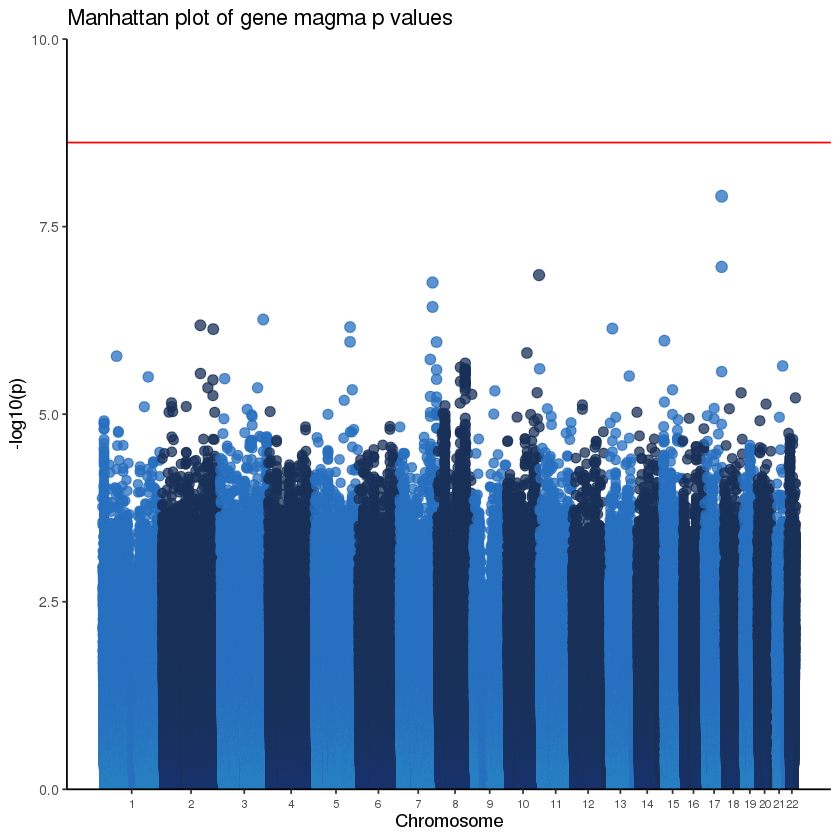

In [12]:
# Now time to draw the manhattan plot without filtering the most significant signals
manhplot <- ggplot(sig.dat, aes(x = BPcum, y = -log10(P), 
                             color = as.factor(CHR), size = -log10(P))) +
  geom_point(alpha = 0.75) +
  geom_hline(yintercept = -log10(sig), color = "red1") + 
  scale_x_continuous(label = axis.set$CHR, breaks = axis.set$center) +
  scale_y_continuous(expand = c(0,0), limits = c(0, ylim)) +
  scale_color_manual(values = rep(c("#276FBF", "#183059"), nCHR)) +
  scale_size_continuous(range = c(0.5,3)) +
  # Add highlighted points and annotation
  geom_point(data=subset(sig.dat, is_highlight=="yes"), color="orange", alpha=0.75) +
  # geom_label_repel(data=subset(sig.dat, is_annotate=="yes"), aes(label=symbol), size=2) +
  labs(x = "Chromosome", 
       y = "-log10(p)",
       title =paste0('Manhattan plot of p values')) + 
  theme_classic() +
  theme( 
    legend.position = "none",
    panel.border = element_blank(),
    panel.grid.major.x = element_blank(),
    panel.grid.minor.x = element_blank(),
    axis.text.x = element_text( size = 7, vjust = 0.5)
  )
png("/home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393/f3393_f4825_2.manhattan.png", width = 6, height = 4, unit='in', res=300)
print(manhplot)
dev.off()
print(manhplot)

In [5]:
library('qqman')

lambda <- median(qchisq(1-data$"P",1), na.rm=TRUE)/qchisq(0.5,1)
ifelse(( min(data$"P", na.rm=TRUE)!=0), ylim <- abs(floor(log10(min(data$"P", na.rm=TRUE)))), ylim <- abs(floor(log10(2.225074e-308))))
# Creating manhattan plot
png('/home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393/f3393_f4825_2.manhattan2.png', width = 6, height = 4, unit='in', res=300)
manhattan_plot <- manhattan(data, chr='CHR', bp='POS', snp='ID', p="P", main = 'Manhattan plot for f3393_f4825_2', ylim = c(0, ylim), cex = 0.6, 
cex.axis = 0.9, col = c("blue4", "orange3"), chrlabs = as.character(c(1:22)))
dev.off()
# Creating qqplot
png('/home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393/f3393_f4825_2.qqplot.png', width = 5, height = 5, unit='in', res=300)
qq_plot <- qq(data$"P", main = 'QQ Plot for f3393_f4825_2', xlim = c(0, 8), ylim = c(0, ylim), pch = 18, col = "blue4", cex = 1.5, las = 1)
dev.off()



For example usage please run: vignette('qqman')



Citation appreciated but not required:

Turner, (2018). qqman: an R package for visualizing GWAS results using Q-Q and manhattan plots. Journal of Open Source Software, 3(25), 731, https://doi.org/10.21105/joss.00731.





[1] 8

png 
  2

png 
  2

> /home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393/f3393_f4825_2.manhattan2.png (182.0 KiB):

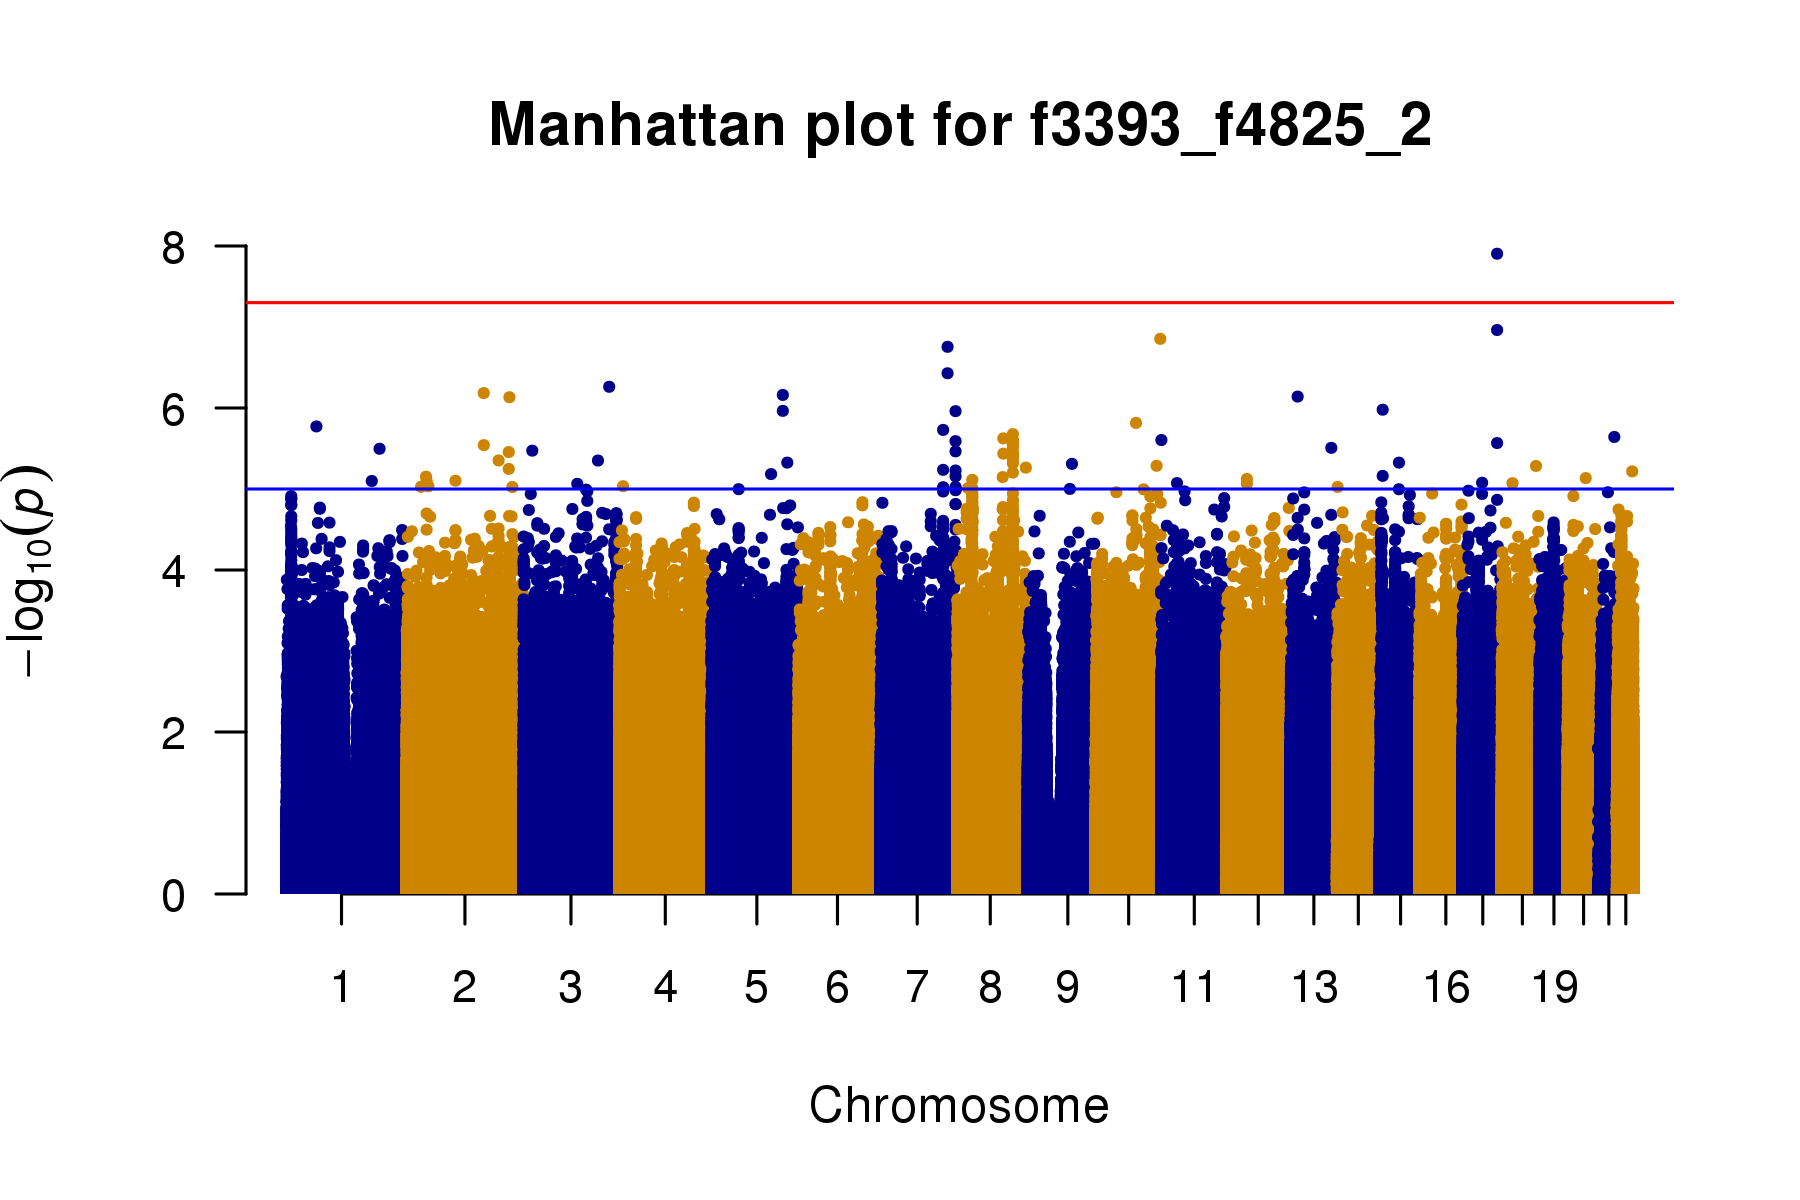

In [6]:
%preview /home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393/f3393_f4825_2.manhattan2.png

> /home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393/f3393_f4825_2.qqplot.png (76.0 KiB):

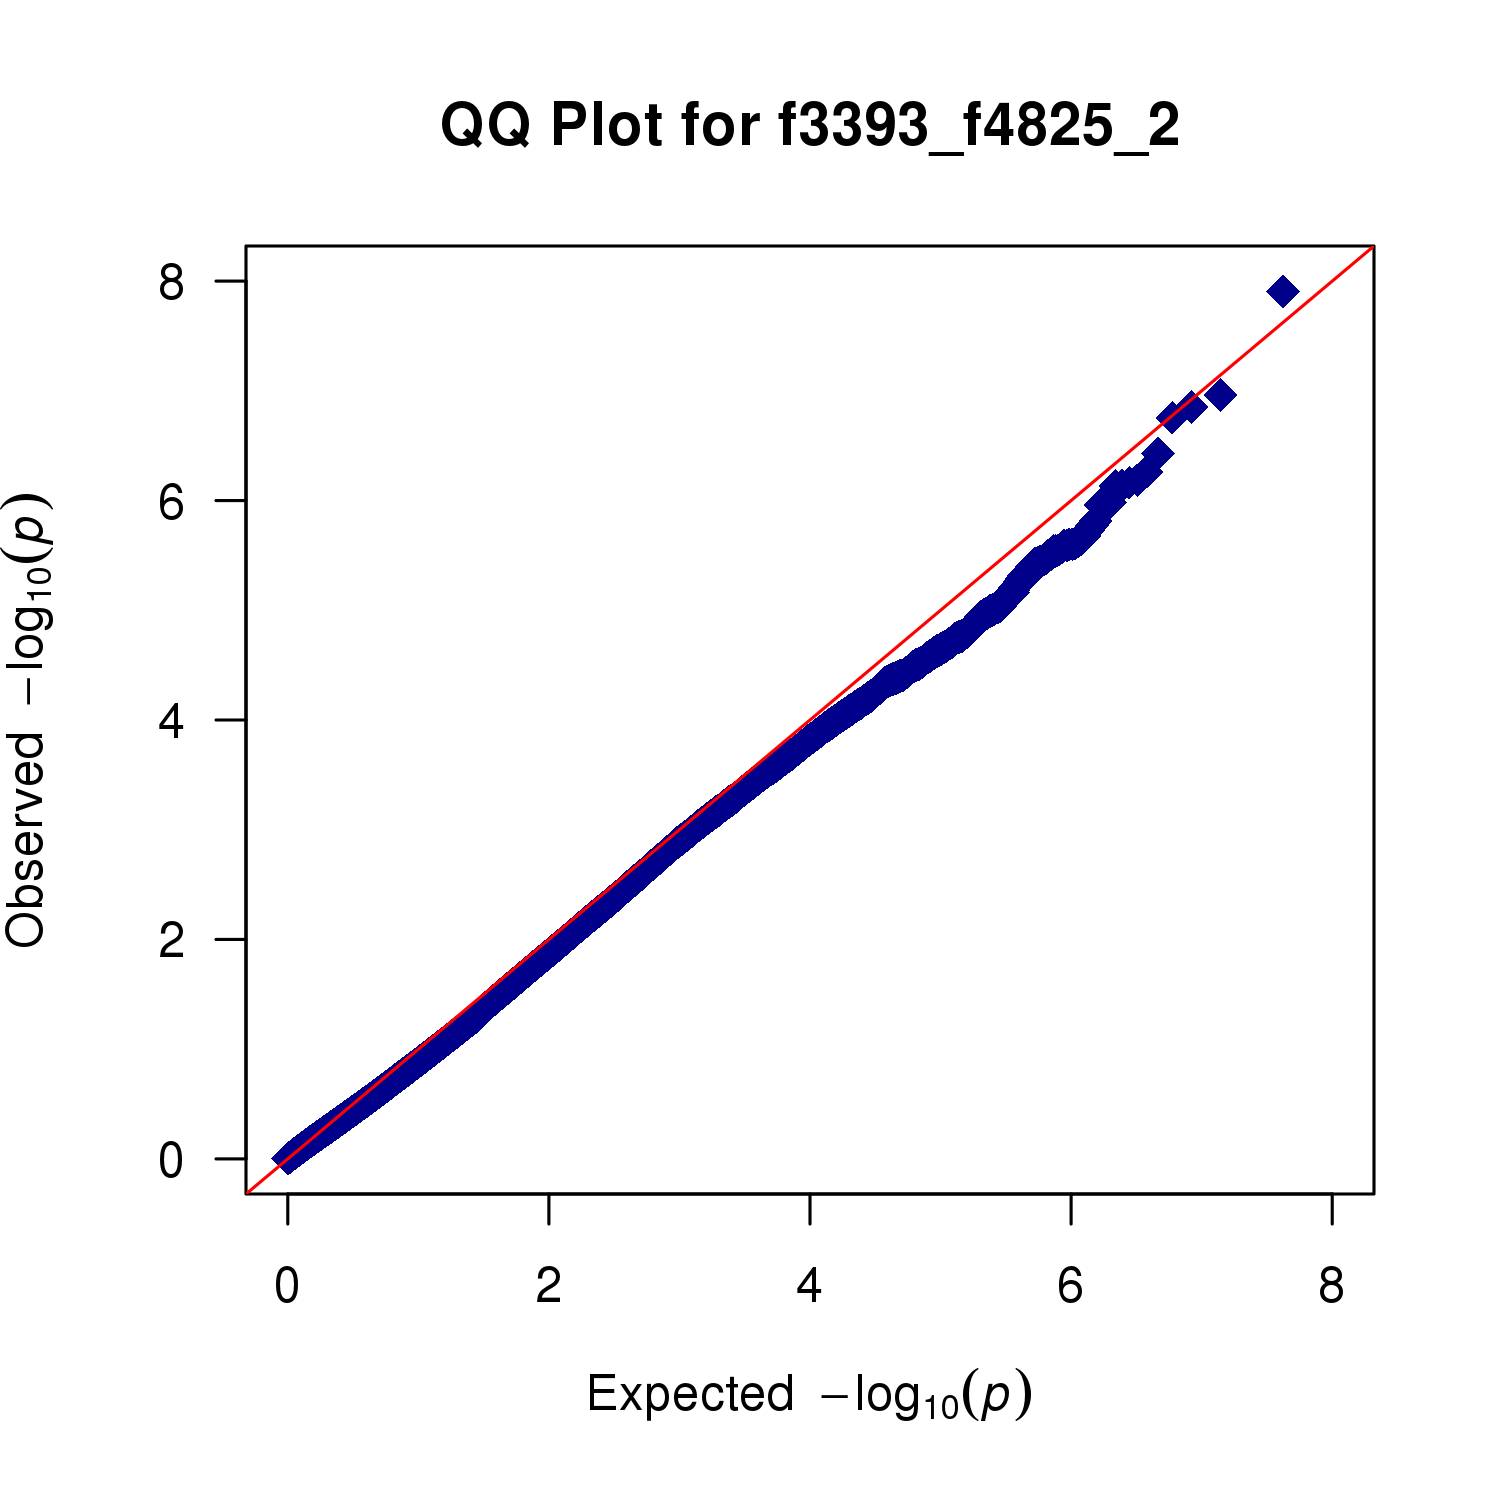

In [7]:
%preview /home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393/f3393_f4825_2.qqplot.png

In [2]:
import pandas as pd 
def result_process(path,noise,trait):
    inter = pd.DataFrame(columns=['CHROM', 'GENPOS', 'ID', 'ALLELE0', 'ALLELE1', 'A1FREQ', 'INFO', 'N',
       'TEST', 'BETA', 'SE', 'CHISQ', 'LOG10P', 'EXTRA'])
    for i in range(1,23):
        df = pd.read_csv(path+"/cache/ukb_imp_chr"+str(i)+"_v3."+noise+"_"+trait+".regenie.gz",compression="gzip",header=0,sep=" ")
        tmp = df[df["TEST"].str.startswith("ADD-INT_SNPx")]
        inter = inter.append(tmp,ignore_index=True)
    inter[["CHROM","GENPOS","ID","LOG10P"]].to_csv(path+"/"+noise+"_interterm.slim.txt",index=False,sep="\t")

In [3]:
path = "/home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393"
noise = "f3393_f4825_1"
trait = "f3393"
result_process(path,noise,trait)

In [4]:
path = "/home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393"
noise = "f3393_f4825_2"
trait = "f3393"
result_process(path,noise,trait)
path = "/home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393"
noise = "f3393_f4836_1"
trait = "f3393"
result_process(path,noise,trait)
path = "/home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393"
noise = "f3393_f4836_2"
trait = "f3393"
result_process(path,noise,trait)
path = "/home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393"
noise = "f3393_f4825_f4836_1"
trait = "f3393"
result_process(path,noise,trait)
path = "/home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393"
noise = "f3393_f4825_f4836_2"
trait = "f3393"
result_process(path,noise,trait)

In [6]:
plots<-function(file,out,noise){
library('dplyr')
library('ggrepel')
#Load your data
data <- read.table(file, sep = "\t",  header=T)
colnames(data) <- c("CHR","POS", "ID", "P")
data$P <- 10^(-data$P)
# Create a subset of the data with variants with P< 0.05 and arrange by chromosome number
sig.dat <- data %>% 
  subset(P < 1) %>%
  arrange(CHR, .by_group=TRUE)
# Add highlight and annotation information
pval <- 0.05/nrow(sig.dat)
sig.dat <- sig.dat %>%
mutate(is_highlight=ifelse(P<=pval, "yes", "no")) %>%
mutate(is_annotate=ifelse(P<=pval, "yes", "no"))     


# Check the list of chromosomes (make sure the sex chr are at the end of the list)
# Get the cumulative base pair position for each variant
nCHR <- length(unique(sig.dat$CHR))
sig.dat$BPcum <- NA
s <- 0
nbp <- c()
for (i in unique(sig.dat$CHR)){
  nbp[i] <- max(sig.dat[sig.dat$CHR == i,]$'POS')
  sig.dat[sig.dat$CHR == i,"BPcum"] <- sig.dat[sig.dat$CHR == i,'POS'] + s
  s <- s + nbp[i]
}

# Calculate the mid point for each chromosome for plotting the x-axis
# Calculate the y-lim 

axis.set <- sig.dat %>% 
  group_by(CHR) %>% 
  summarize(center = (max(BPcum) + min(BPcum)) / 2)
if (0 == 0) ylim <- abs(floor(log10(min(sig.dat$P)))) + 2 
sig <- 0.05/nrow(sig.dat)
# Now time to draw the manhattan plot without filtering the most significant signals
manhplot <- ggplot(sig.dat, aes(x = BPcum, y = -log10(P), 
                             color = as.factor(CHR), size = -log10(P))) +
  geom_point(alpha = 0.75) +
  geom_hline(yintercept = -log10(sig), color = "red1") + 
  scale_x_continuous(label = axis.set$CHR, breaks = axis.set$center) +
  scale_y_continuous(expand = c(0,0), limits = c(0, ylim)) +
  scale_color_manual(values = rep(c("#276FBF", "#183059"), nCHR)) +
  scale_size_continuous(range = c(0.5,3)) +
  # Add highlighted points and annotation
  geom_point(data=subset(sig.dat, is_highlight=="yes"), color="orange", alpha=0.75) +
  # geom_label_repel(data=subset(sig.dat, is_annotate=="yes"), aes(label=symbol), size=2) +
  labs(x = "Chromosome", 
       y = "-log10(p)",
       title =paste0('Manhattan plot for ',noise)) + 
  theme_classic() +
  theme( 
    legend.position = "none",
    panel.border = element_blank(),
    panel.grid.major.x = element_blank(),
    panel.grid.minor.x = element_blank(),
    axis.text.x = element_text( size = 7, vjust = 0.5)
  )
png(paste0(out,"/",noise,".manhattan.png"), width = 6, height = 4, unit='in', res=300)
print(manhplot)
dev.off()

library('qqman')
lambda <- median(qchisq(1-data$"P",1), na.rm=TRUE)/qchisq(0.5,1)
ifelse(( min(data$"P", na.rm=TRUE)!=0), ylim <- abs(floor(log10(min(data$"P", na.rm=TRUE)))), ylim <- abs(floor(log10(2.225074e-308))))
# Creating manhattan plot
png(paste0(out,"/",noise,".manhattan2.png"), width = 6, height = 4, unit='in', res=300)
manhattan_plot <- manhattan(data, chr='CHR', bp='POS', snp='ID', p="P", main = paste0('Manhattan plot for ',noise), ylim = c(0, ylim), cex = 0.6, 
cex.axis = 0.9, col = c("blue4", "orange3"), chrlabs = as.character(c(1:22)))
dev.off()
# Creating qqplot
png(paste0(out,"/",noise,".qqplot.png"), width = 5, height = 5, unit='in', res=300)
qq_plot <- qq(data$"P", main = paste0('QQ Plot for ',noise), xlim = c(0, 8), ylim = c(0, ylim), pch = 18, col = "blue4", cex = 1.5, las = 1)
dev.off()
}

In [8]:
out<-"/home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393"
noise<-"f3393_f4825_1"
file<-paste0(out,"/",noise,"_interterm.slim.txt")
plots(file,out,noise)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: ggplot2



For example usage please run: vignette('qqman')



Citation appreciated but not required:

Turner, (2018). qqman: an R package for visualizing GWAS results using Q-Q and manhattan plots. Journal of Open Source Software, 3(25), 731, https://doi.org/10.21105/joss.00731.





png 
  2

In [10]:
out<-"/home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393"
noise<-"f3393_f4825_2"
file<-paste0(out,"/",noise,"_interterm.slim.txt")
plots(file,out,noise)

In [ ]:
out<-"/home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393"
noise<-"f3393_f4836_1"
file<-paste0(out,"/",noise,"_interterm.slim.txt")
plots(file,out,noise)

In [ ]:
out<-"/home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393"
noise<-"f3393_f4836_2"
file<-paste0(out,"/",noise,"_interterm.slim.txt")
plots(file,out,noise)

In [ ]:
out<-"/home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393"
noise<-"f3393_f4825_f4836_1"
file<-paste0(out,"/",noise,"_interterm.slim.txt")
plots(file,out,noise)

In [ ]:
out<-"/home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393"
noise<-"f3393_f4825_f4836_2"
file<-paste0(out,"/",noise,"_interterm.slim.txt")
plots(file,out,noise)

In [3]:
ls /home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2247/cache | grep f2247_f4825_1_f2247.regenie.gz | wc -l

22


In [5]:
ls /home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2247/cache | grep f2247_f4836_1_f2247.regenie.gz | wc -l

22


In [7]:
ls /home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2247/cache | grep f2247_f4825_f4836_1_f2247.regenie.gz | wc -l

22


In [8]:
ls /home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2257/cache | grep f2257_f4825_1_f2257.regenie.gz | wc -l

13


In [9]:
ls /home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2257/cache | grep f2257_f4836_1_f2257.regenie.gz | wc -l

12


In [2]:
ls /home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2257/cache | grep f2257_f4825_f4836_1_f2257.regenie.gz | wc -l

22


In [3]:
ls /home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2247_f2257/cache | grep f2247_f2257_f4825_1_f2247_f2257.regenie.gz | wc -l

22


In [4]:
ls /home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2247_f2257/cache | grep f2247_f2257_f4836_1_f2247_f2257.regenie.gz | wc -l

22


In [1]:
ls /home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2247_f2257/cache | grep f2247_f2257_f4825_f4836_1_f2247_f2257.regenie.gz | wc -l

22


In [ ]:
out<-"/home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2247"
noise<-"f2247_f4825_1"
file<-paste0(out,"/",noise,"_interterm.slim.txt")
plots(file,out,noise)
out<-"/home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2247"
noise<-"f2247_f4836_1"
file<-paste0(out,"/",noise,"_interterm.slim.txt")
plots(file,out,noise)
out<-"/home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2247"
noise<-"f2247_f4825_f4836_1"
file<-paste0(out,"/",noise,"_interterm.slim.txt")
plots(file,out,noise)

In [ ]:
out<-"/home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2257"
noise<-"f2257_f4825_1"
file<-paste0(out,"/",noise,"_interterm.slim.txt")
plots(file,out,noise)
out<-"/home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2257"
noise<-"f2257_f4836_1"
file<-paste0(out,"/",noise,"_interterm.slim.txt")
plots(file,out,noise)
out<-"/home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2257"
noise<-"f2257_f4825_f4836_1"
file<-paste0(out,"/",noise,"_interterm.slim.txt")
plots(file,out,noise)

In [ ]:
out<-"/home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2247_f2257"
noise<-"f2247_f2257_f4825_1"
file<-paste0(out,"/",noise,"_interterm.slim.txt")
plots(file,out,noise)
out<-"/home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2247_f2257"
noise<-"f2247_f2257_f4836_1"
file<-paste0(out,"/",noise,"_interterm.slim.txt")
plots(file,out,noise)
out<-"/home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2247_f2257"
noise<-"f2247_f2257_f4825_f4836_1"
file<-paste0(out,"/",noise,"_interterm.slim.txt")
plots(file,out,noise)

## Annotation for top interactions

In [2]:
tpl_file=~/working/bioworkflows/admin/csg.yml
sos_notebook=~/working/interaction/newv/Regenie_interaction_GxE.ipynb
lmm_dir_regenie=~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393/annotation
sumstatsFile=`echo ~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393/cache/ukb_imp_chr{1..22}_v3.f3393_f4825_1_f3393.regenie.gz`
hg=19
job_size=1
humandb=/mnt/mfs/statgen/isabelle/REF/humandb
xref_path=/mnt/mfs/statgen/isabelle/REF/humandb
#p_filter=5e-08
k=100
anno_sbatch=$lmm_dir_regenie/f3393_annovar_$(date +"%Y-%m-%d").sbatch
container_lmm=~/containers/lmm.sif
container_annovar=~/containers/gatk4-annovar.sif


annovar_args="""annovar 
    --cwd $lmm_dir_regenie 
    --sumstatsFile $sumstatsFile
    --k $k 
    --hg $hg 
    --job_size $job_size 
    --humandb $humandb
    --xref_path $xref_path 
    --container_annovar $container_annovar 
    --container_lmm $container_lmm
"""

sos run ~/working/UKBB_GWAS_dev/admin/Get_Job_Script.ipynb csg\
    --template-file $tpl_file \
    --workflow-file $sos_notebook \
    --to-script $anno_sbatch \
    --args "$annovar_args"

INFO: Running csg: Configuration for Columbia csg partition cluster
INFO: csg is completed.
INFO: csg output:   /home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393/annotation/f3393_annovar_2022-04-27.sbatch
INFO: Workflow csg (ID=w7fa2d0f4d26b76bb) is executed successfully with 1 completed step.


In [2]:
tpl_file=~/working/bioworkflows/admin/csg.yml
sos_notebook=~/working/interaction/newv/Regenie_interaction_GxE.ipynb
lmm_dir_regenie=~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393/annotation
sumstatsFile=`echo ~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393/cache/ukb_imp_chr{1..22}_v3.f3393_f4836_1_f3393.regenie.gz`
hg=19
job_size=1
humandb=/mnt/mfs/statgen/isabelle/REF/humandb
xref_path=/mnt/mfs/statgen/isabelle/REF/humandb
#p_filter=5e-08
k=100
anno_sbatch=$lmm_dir_regenie/f3393_f4836_1_annovar_$(date +"%Y-%m-%d").sbatch
container_lmm=~/containers/lmm.sif
container_annovar=~/containers/gatk4-annovar.sif


annovar_args="""annovar 
    --cwd $lmm_dir_regenie 
    --sumstatsFile $sumstatsFile
    --k $k 
    --hg $hg 
    --job_size $job_size 
    --humandb $humandb
    --xref_path $xref_path 
    --container_annovar $container_annovar 
    --container_lmm $container_lmm
"""

sos run ~/working/UKBB_GWAS_dev/admin/Get_Job_Script.ipynb csg\
    --template-file $tpl_file \
    --workflow-file $sos_notebook \
    --to-script $anno_sbatch \
    --args "$annovar_args"

tpl_file=~/working/bioworkflows/admin/csg.yml
sos_notebook=~/working/interaction/newv/Regenie_interaction_GxE.ipynb
lmm_dir_regenie=~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393/annotation
sumstatsFile=`echo ~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393/cache/ukb_imp_chr{1..22}_v3.f3393_f4825_f4836_1_f3393.regenie.gz`
hg=19
job_size=1
humandb=/mnt/mfs/statgen/isabelle/REF/humandb
xref_path=/mnt/mfs/statgen/isabelle/REF/humandb
#p_filter=5e-08
k=100
anno_sbatch=$lmm_dir_regenie/f3393_f4825_f4836_1_annovar_$(date +"%Y-%m-%d").sbatch
container_lmm=~/containers/lmm.sif
container_annovar=~/containers/gatk4-annovar.sif


annovar_args="""annovar 
    --cwd $lmm_dir_regenie 
    --sumstatsFile $sumstatsFile
    --k $k 
    --hg $hg 
    --job_size $job_size 
    --humandb $humandb
    --xref_path $xref_path 
    --container_annovar $container_annovar 
    --container_lmm $container_lmm
"""

sos run ~/working/UKBB_GWAS_dev/admin/Get_Job_Script.ipynb csg\
    --template-file $tpl_file \
    --workflow-file $sos_notebook \
    --to-script $anno_sbatch \
    --args "$annovar_args"


tpl_file=~/working/bioworkflows/admin/csg.yml
sos_notebook=~/working/interaction/newv/Regenie_interaction_GxE.ipynb
lmm_dir_regenie=~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393/annotation
sumstatsFile=`echo ~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393/cache/ukb_imp_chr{1..22}_v3.f3393_f4825_2_f3393.regenie.gz`
hg=19
job_size=1
humandb=/mnt/mfs/statgen/isabelle/REF/humandb
xref_path=/mnt/mfs/statgen/isabelle/REF/humandb
#p_filter=5e-08
k=100
anno_sbatch=$lmm_dir_regenie/f3393_f4825_2_annovar_$(date +"%Y-%m-%d").sbatch
container_lmm=~/containers/lmm.sif
container_annovar=~/containers/gatk4-annovar.sif


annovar_args="""annovar 
    --cwd $lmm_dir_regenie 
    --sumstatsFile $sumstatsFile
    --k $k 
    --hg $hg 
    --job_size $job_size 
    --humandb $humandb
    --xref_path $xref_path 
    --container_annovar $container_annovar 
    --container_lmm $container_lmm
"""

sos run ~/working/UKBB_GWAS_dev/admin/Get_Job_Script.ipynb csg\
    --template-file $tpl_file \
    --workflow-file $sos_notebook \
    --to-script $anno_sbatch \
    --args "$annovar_args"

tpl_file=~/working/bioworkflows/admin/csg.yml
sos_notebook=~/working/interaction/newv/Regenie_interaction_GxE.ipynb
lmm_dir_regenie=~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393/annotation
sumstatsFile=`echo ~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393/cache/ukb_imp_chr{1..22}_v3.f3393_f4836_2_f3393.regenie.gz`
hg=19
job_size=1
humandb=/mnt/mfs/statgen/isabelle/REF/humandb
xref_path=/mnt/mfs/statgen/isabelle/REF/humandb
#p_filter=5e-08
k=100
anno_sbatch=$lmm_dir_regenie/f3393_f4836_2_annovar_$(date +"%Y-%m-%d").sbatch
container_lmm=~/containers/lmm.sif
container_annovar=~/containers/gatk4-annovar.sif


annovar_args="""annovar 
    --cwd $lmm_dir_regenie 
    --sumstatsFile $sumstatsFile
    --k $k 
    --hg $hg 
    --job_size $job_size 
    --humandb $humandb
    --xref_path $xref_path 
    --container_annovar $container_annovar 
    --container_lmm $container_lmm
"""

sos run ~/working/UKBB_GWAS_dev/admin/Get_Job_Script.ipynb csg\
    --template-file $tpl_file \
    --workflow-file $sos_notebook \
    --to-script $anno_sbatch \
    --args "$annovar_args"

tpl_file=~/working/bioworkflows/admin/csg.yml
sos_notebook=~/working/interaction/newv/Regenie_interaction_GxE.ipynb
lmm_dir_regenie=~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393/annotation
sumstatsFile=`echo ~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393/cache/ukb_imp_chr{1..22}_v3.f3393_f4825_f4836_2_f3393.regenie.gz`
hg=19
job_size=1
humandb=/mnt/mfs/statgen/isabelle/REF/humandb
xref_path=/mnt/mfs/statgen/isabelle/REF/humandb
#p_filter=5e-08
k=100
anno_sbatch=$lmm_dir_regenie/f3393_f4825_f4836_2_annovar_$(date +"%Y-%m-%d").sbatch
container_lmm=~/containers/lmm.sif
container_annovar=~/containers/gatk4-annovar.sif


annovar_args="""annovar 
    --cwd $lmm_dir_regenie 
    --sumstatsFile $sumstatsFile
    --k $k 
    --hg $hg 
    --job_size $job_size 
    --humandb $humandb
    --xref_path $xref_path 
    --container_annovar $container_annovar 
    --container_lmm $container_lmm
"""

sos run ~/working/UKBB_GWAS_dev/admin/Get_Job_Script.ipynb csg\
    --template-file $tpl_file \
    --workflow-file $sos_notebook \
    --to-script $anno_sbatch \
    --args "$annovar_args"

INFO: Running csg: Configuration for Columbia csg partition cluster
INFO: csg is completed.
INFO: csg output:   /home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393/annotation/f3393_f4836_1_annovar_2022-04-05.sbatch
INFO: Workflow csg (ID=wa7f45e5fff7a346f) is executed successfully with 1 completed step.
INFO: Running csg: Configuration for Columbia csg partition cluster
INFO: csg is completed.
INFO: csg output:   /home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393/annotation/f3393_f4825_f4836_1_annovar_2022-04-05.sbatch
INFO: Workflow csg (ID=w43cbb8a5474bd9aa) is executed successfully with 1 completed step.
INFO: Running csg: Configuration for Columbia csg partition cluster
INFO: csg is completed.
INFO: csg output:   /home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393/annotation

In [3]:
tpl_file=~/working/bioworkflows/admin/csg.yml
sos_notebook=~/working/interaction/newv/Regenie_interaction_GxE.ipynb
lmm_dir_regenie=~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2247/annotation
sumstatsFile=`echo ~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2247/cache/ukb_imp_chr{1..22}_v3.f2247_f4825_1_f2247.regenie.gz`
hg=19
job_size=1
humandb=/mnt/mfs/statgen/isabelle/REF/humandb
xref_path=/mnt/mfs/statgen/isabelle/REF/humandb
#p_filter=5e-08
k=100
anno_sbatch=$lmm_dir_regenie/f2247_f4825_1_annovar_$(date +"%Y-%m-%d").sbatch
container_lmm=~/containers/lmm.sif
container_annovar=~/containers/gatk4-annovar.sif


annovar_args="""annovar 
    --cwd $lmm_dir_regenie 
    --sumstatsFile $sumstatsFile
    --k $k 
    --hg $hg 
    --job_size $job_size 
    --humandb $humandb
    --xref_path $xref_path 
    --container_annovar $container_annovar 
    --container_lmm $container_lmm
"""

sos run ~/working/UKBB_GWAS_dev/admin/Get_Job_Script.ipynb csg\
    --template-file $tpl_file \
    --workflow-file $sos_notebook \
    --to-script $anno_sbatch \
    --args "$annovar_args"

tpl_file=~/working/bioworkflows/admin/csg.yml
sos_notebook=~/working/interaction/newv/Regenie_interaction_GxE.ipynb
lmm_dir_regenie=~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2247/annotation
sumstatsFile=`echo ~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2247/cache/ukb_imp_chr{1..22}_v3.f2247_f4836_1_f2247.regenie.gz`
hg=19
job_size=1
humandb=/mnt/mfs/statgen/isabelle/REF/humandb
xref_path=/mnt/mfs/statgen/isabelle/REF/humandb
#p_filter=5e-08
k=100
anno_sbatch=$lmm_dir_regenie/f2247_f4836_1_annovar_$(date +"%Y-%m-%d").sbatch
container_lmm=~/containers/lmm.sif
container_annovar=~/containers/gatk4-annovar.sif


annovar_args="""annovar 
    --cwd $lmm_dir_regenie 
    --sumstatsFile $sumstatsFile
    --k $k 
    --hg $hg 
    --job_size $job_size 
    --humandb $humandb
    --xref_path $xref_path 
    --container_annovar $container_annovar 
    --container_lmm $container_lmm
"""

sos run ~/working/UKBB_GWAS_dev/admin/Get_Job_Script.ipynb csg\
    --template-file $tpl_file \
    --workflow-file $sos_notebook \
    --to-script $anno_sbatch \
    --args "$annovar_args"

tpl_file=~/working/bioworkflows/admin/csg.yml
sos_notebook=~/working/interaction/newv/Regenie_interaction_GxE.ipynb
lmm_dir_regenie=~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2247/annotation
sumstatsFile=`echo ~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2247/cache/ukb_imp_chr{1..22}_v3.f2247_f4825_f4836_1_f2247.regenie.gz`
hg=19
job_size=1
humandb=/mnt/mfs/statgen/isabelle/REF/humandb
xref_path=/mnt/mfs/statgen/isabelle/REF/humandb
#p_filter=5e-08
k=100
anno_sbatch=$lmm_dir_regenie/f2247_f4825_f4836_1_annovar_$(date +"%Y-%m-%d").sbatch
container_lmm=~/containers/lmm.sif
container_annovar=~/containers/gatk4-annovar.sif


annovar_args="""annovar 
    --cwd $lmm_dir_regenie 
    --sumstatsFile $sumstatsFile
    --k $k 
    --hg $hg 
    --job_size $job_size 
    --humandb $humandb
    --xref_path $xref_path 
    --container_annovar $container_annovar 
    --container_lmm $container_lmm
"""

sos run ~/working/UKBB_GWAS_dev/admin/Get_Job_Script.ipynb csg\
    --template-file $tpl_file \
    --workflow-file $sos_notebook \
    --to-script $anno_sbatch \
    --args "$annovar_args"

INFO: Running csg: Configuration for Columbia csg partition cluster
INFO: csg is completed.
INFO: csg output:   /home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2247/annotation/f2247_f4825_1_annovar_2022-04-05.sbatch
INFO: Workflow csg (ID=w82e46912b86bccd4) is executed successfully with 1 completed step.
INFO: Running csg: Configuration for Columbia csg partition cluster
INFO: csg is completed.
INFO: csg output:   /home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2247/annotation/f2247_f4836_1_annovar_2022-04-05.sbatch
INFO: Workflow csg (ID=wa776695e81be76be) is executed successfully with 1 completed step.
INFO: Running csg: Configuration for Columbia csg partition cluster
INFO: csg is completed.
INFO: csg output:   /home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2247/annotation/f2247

In [4]:
tpl_file=~/working/bioworkflows/admin/csg.yml
sos_notebook=~/working/interaction/newv/Regenie_interaction_GxE.ipynb
lmm_dir_regenie=~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2257/annotation
sumstatsFile=`echo ~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2257/cache/ukb_imp_chr{1..22}_v3.f2257_f4825_1_f2257.regenie.gz`
hg=19
job_size=1
humandb=/mnt/mfs/statgen/isabelle/REF/humandb
xref_path=/mnt/mfs/statgen/isabelle/REF/humandb
#p_filter=5e-08
k=100
anno_sbatch=$lmm_dir_regenie/f2257_f4825_1_annovar_$(date +"%Y-%m-%d").sbatch
container_lmm=~/containers/lmm.sif
container_annovar=~/containers/gatk4-annovar.sif


annovar_args="""annovar 
    --cwd $lmm_dir_regenie 
    --sumstatsFile $sumstatsFile
    --k $k 
    --hg $hg 
    --job_size $job_size 
    --humandb $humandb
    --xref_path $xref_path 
    --container_annovar $container_annovar 
    --container_lmm $container_lmm
"""

sos run ~/working/UKBB_GWAS_dev/admin/Get_Job_Script.ipynb csg\
    --template-file $tpl_file \
    --workflow-file $sos_notebook \
    --to-script $anno_sbatch \
    --args "$annovar_args"

tpl_file=~/working/bioworkflows/admin/csg.yml
sos_notebook=~/working/interaction/newv/Regenie_interaction_GxE.ipynb
lmm_dir_regenie=~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2257/annotation
sumstatsFile=`echo ~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2257/cache/ukb_imp_chr{1..22}_v3.f2257_f4836_1_f2257.regenie.gz`
hg=19
job_size=1
humandb=/mnt/mfs/statgen/isabelle/REF/humandb
xref_path=/mnt/mfs/statgen/isabelle/REF/humandb
#p_filter=5e-08
k=100
anno_sbatch=$lmm_dir_regenie/f2257_f4836_1_annovar_$(date +"%Y-%m-%d").sbatch
container_lmm=~/containers/lmm.sif
container_annovar=~/containers/gatk4-annovar.sif


annovar_args="""annovar 
    --cwd $lmm_dir_regenie 
    --sumstatsFile $sumstatsFile
    --k $k 
    --hg $hg 
    --job_size $job_size 
    --humandb $humandb
    --xref_path $xref_path 
    --container_annovar $container_annovar 
    --container_lmm $container_lmm
"""

sos run ~/working/UKBB_GWAS_dev/admin/Get_Job_Script.ipynb csg\
    --template-file $tpl_file \
    --workflow-file $sos_notebook \
    --to-script $anno_sbatch \
    --args "$annovar_args"

tpl_file=~/working/bioworkflows/admin/csg.yml
sos_notebook=~/working/interaction/newv/Regenie_interaction_GxE.ipynb
lmm_dir_regenie=~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2257/annotation
sumstatsFile=`echo ~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2257/cache/ukb_imp_chr{1..22}_v3.f2257_f4825_f4836_1_f2257.regenie.gz`
hg=19
job_size=1
humandb=/mnt/mfs/statgen/isabelle/REF/humandb
xref_path=/mnt/mfs/statgen/isabelle/REF/humandb
#p_filter=5e-08
k=100
anno_sbatch=$lmm_dir_regenie/f2257_f4825_f4836_1_annovar_$(date +"%Y-%m-%d").sbatch
container_lmm=~/containers/lmm.sif
container_annovar=~/containers/gatk4-annovar.sif


annovar_args="""annovar 
    --cwd $lmm_dir_regenie 
    --sumstatsFile $sumstatsFile
    --k $k 
    --hg $hg 
    --job_size $job_size 
    --humandb $humandb
    --xref_path $xref_path 
    --container_annovar $container_annovar 
    --container_lmm $container_lmm
"""

sos run ~/working/UKBB_GWAS_dev/admin/Get_Job_Script.ipynb csg\
    --template-file $tpl_file \
    --workflow-file $sos_notebook \
    --to-script $anno_sbatch \
    --args "$annovar_args"

INFO: Running csg: Configuration for Columbia csg partition cluster
INFO: csg is completed.
INFO: csg output:   /home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2257/annotation/f2257_f4825_1_annovar_2022-04-05.sbatch
INFO: Workflow csg (ID=w9e6f9b255b55fe27) is executed successfully with 1 completed step.
INFO: Running csg: Configuration for Columbia csg partition cluster
INFO: csg is completed.
INFO: csg output:   /home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2257/annotation/f2257_f4836_1_annovar_2022-04-05.sbatch
INFO: Workflow csg (ID=weec02ad2814e38c2) is executed successfully with 1 completed step.
INFO: Running csg: Configuration for Columbia csg partition cluster
INFO: csg is completed.
INFO: csg output:   /home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2257/annotation/f2257

In [1]:
tpl_file=~/working/bioworkflows/admin/csg.yml
sos_notebook=~/working/interaction/newv/Regenie_interaction_GxE.ipynb
lmm_dir_regenie=~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2247_f2257/annotation
sumstatsFile=`echo ~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2247_f2257/cache/ukb_imp_chr{1..22}_v3.f2247_f2257_f4825_1_f2247_f2257.regenie.gz`
hg=19
job_size=1
humandb=/mnt/mfs/statgen/isabelle/REF/humandb
xref_path=/mnt/mfs/statgen/isabelle/REF/humandb
#p_filter=5e-08
k=100
anno_sbatch=$lmm_dir_regenie/f2247_f2257_f4825_1_annovar_$(date +"%Y-%m-%d").sbatch
container_lmm=~/containers/lmm.sif
container_annovar=~/containers/gatk4-annovar.sif


annovar_args="""annovar 
    --cwd $lmm_dir_regenie 
    --sumstatsFile $sumstatsFile
    --k $k 
    --hg $hg 
    --job_size $job_size 
    --humandb $humandb
    --xref_path $xref_path 
    --container_annovar $container_annovar 
    --container_lmm $container_lmm
"""

sos run ~/working/UKBB_GWAS_dev/admin/Get_Job_Script.ipynb csg\
    --template-file $tpl_file \
    --workflow-file $sos_notebook \
    --to-script $anno_sbatch \
    --args "$annovar_args"

tpl_file=~/working/bioworkflows/admin/csg.yml
sos_notebook=~/working/interaction/newv/Regenie_interaction_GxE.ipynb
lmm_dir_regenie=~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2247_f2257/annotation
sumstatsFile=`echo ~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2247_f2257/cache/ukb_imp_chr{1..22}_v3.f2247_f2257_f4836_1_f2247_f2257.regenie.gz`
hg=19
job_size=1
humandb=/mnt/mfs/statgen/isabelle/REF/humandb
xref_path=/mnt/mfs/statgen/isabelle/REF/humandb
#p_filter=5e-08
k=100
anno_sbatch=$lmm_dir_regenie/f2247_f2257_f4836_1_annovar_$(date +"%Y-%m-%d").sbatch
container_lmm=~/containers/lmm.sif
container_annovar=~/containers/gatk4-annovar.sif


annovar_args="""annovar 
    --cwd $lmm_dir_regenie 
    --sumstatsFile $sumstatsFile
    --k $k 
    --hg $hg 
    --job_size $job_size 
    --humandb $humandb
    --xref_path $xref_path 
    --container_annovar $container_annovar 
    --container_lmm $container_lmm
"""

sos run ~/working/UKBB_GWAS_dev/admin/Get_Job_Script.ipynb csg\
    --template-file $tpl_file \
    --workflow-file $sos_notebook \
    --to-script $anno_sbatch \
    --args "$annovar_args"

tpl_file=~/working/bioworkflows/admin/csg.yml
sos_notebook=~/working/interaction/newv/Regenie_interaction_GxE.ipynb
lmm_dir_regenie=~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2247_f2257/annotation
sumstatsFile=`echo ~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2247_f2257/cache/ukb_imp_chr{1..22}_v3.f2247_f2257_f4825_f4836_1_f2247_f2257.regenie.gz`
hg=19
job_size=1
humandb=/mnt/mfs/statgen/isabelle/REF/humandb
xref_path=/mnt/mfs/statgen/isabelle/REF/humandb
#p_filter=5e-08
k=100
anno_sbatch=$lmm_dir_regenie/f2247_f2257_f4825_f4836_1_annovar_$(date +"%Y-%m-%d").sbatch
container_lmm=~/containers/lmm.sif
container_annovar=~/containers/gatk4-annovar.sif


annovar_args="""annovar 
    --cwd $lmm_dir_regenie 
    --sumstatsFile $sumstatsFile
    --k $k 
    --hg $hg 
    --job_size $job_size 
    --humandb $humandb
    --xref_path $xref_path 
    --container_annovar $container_annovar 
    --container_lmm $container_lmm
"""

sos run ~/working/UKBB_GWAS_dev/admin/Get_Job_Script.ipynb csg\
    --template-file $tpl_file \
    --workflow-file $sos_notebook \
    --to-script $anno_sbatch \
    --args "$annovar_args"

INFO: Running csg: Configuration for Columbia csg partition cluster
INFO: csg is completed.
INFO: csg output:   /home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2247_f2257/annotation/f2247_f2257_f4825_1_annovar_2022-04-27.sbatch
INFO: Workflow csg (ID=w1d22a4de64264ed6) is executed successfully with 1 completed step.
INFO: Running csg: Configuration for Columbia csg partition cluster
INFO: csg is completed.
INFO: csg output:   /home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2247_f2257/annotation/f2247_f2257_f4836_1_annovar_2022-04-27.sbatch
INFO: Workflow csg (ID=w33911a2c5d89bd19) is executed successfully with 1 completed step.
INFO: Running csg: Configuration for Columbia csg partition cluster
INFO: csg is completed.
INFO: csg output:   /home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_1

In [11]:
sort -g -r -k 4  ~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393/f3393_f4825_1_interterm.slim.txt | head -n 10

17	71760219	rs188919782	7.82462
10	134008790	rs112920518	7.36038
17	71765698	rs549946100	6.87779
7	139054107	rs6949890	6.64382
5	148778496	rs428255	6.53976
13	33984341	rs148479734	6.39608
5	148778615	rs11738792	6.35661
7	139033476	rs36032227	6.2977
21	43306587	rs117895700	6.19701
3	177480667	rs115482323	6.00333
sort: write failed: 'standard output': Broken pipe
sort: write error


In [12]:
sort -g -r -k 4 ~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393/f3393_f4836_1_interterm.slim.txt | head -n 10

1	68861192	rs3125926	7.05908
1	68861257	rs3118389	6.98633
1	68861762	rs9436396	6.84501
1	168722318	rs188680040	6.69593
7	139061156	rs192547210	6.58448
16	7585545	rs1507020	5.8258
7	19999785	rs62455460	5.82403
8	27960157	rs531623247	5.75017
1	68862622	rs3125927	5.74945
9	98815145	rs1547205	5.67243
sort: write failed: 'standard output': Broken pipe
sort: write error


In [13]:
sort -g -r -k 4 ~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393/f3393_f4825_f4836_1_interterm.slim.txt | head -n 10

17	71760219	rs188919782	7.02171
13	33984341	rs148479734	6.6862
17	71765698	rs549946100	6.40187
8	95666404	rs149940571	6.33247
7	104176562	rs118182013	6.32095
10	134008790	rs112920518	6.23647
11	49068202	rs72904498	6.17668
7	114084934	rs75180486	6.11654
7	104189070	rs181425868	6.11202
8	95697193	rs79419404	6.03484
sort: write failed: 'standard output': Broken pipe
sort: write error


In [14]:
sort -g -r -k 4  ~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393/f3393_f4825_2_interterm.slim.txt | head -n 10

17	71760219	rs188919782	7.90477
17	71765698	rs549946100	6.96304
10	134008790	rs112920518	6.85384
7	139054107	rs6949890	6.75511
7	139033476	rs36032227	6.42886
3	177480667	rs115482323	6.26193
2	160239298	rs141120127	6.18439
5	148778496	rs428255	6.16117
13	33984341	rs148479734	6.14098
2	213539406	rs142107999	6.13323
sort: write failed: 'standard output': Broken pipe
sort: write error


In [15]:
sort -g -r -k 4 ~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393/f3393_f4836_2_interterm.slim.txt | head -n 10

1	68861192	rs3125926	6.94634
1	68861257	rs3118389	6.88839
1	168722318	rs188680040	6.77131
7	139061156	rs192547210	6.76525
1	68861762	rs9436396	6.7504
8	27960157	rs531623247	5.94244
16	7585545	rs1507020	5.84302
7	19999785	rs62455460	5.80223
9	98815145	rs1547205	5.75987
6	79352268	rs663954	5.61504
sort: write failed: 'standard output': Broken pipe
sort: write error


In [16]:
sort -g -r -k 4 ~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393/f3393_f4825_f4836_2_interterm.slim.txt | head -n 10

17	71760219	rs188919782	7.13079
13	33984341	rs148479734	6.73827
8	95666404	rs149940571	6.5628
17	71765698	rs549946100	6.51552
7	114084934	rs75180486	6.23917
8	95697193	rs79419404	6.23354
18	47684058	rs556664749	6.19434
22	25666760	rs4377419	6.10982
7	104176562	rs118182013	6.02136
3	154172706	rs13080633	6.0147
sort: write failed: 'standard output': Broken pipe
sort: write error


In [17]:
wc -l  ~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393/f3393_f4825_1_interterm.slim.txt | head -n 10

20860490 /home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393/f3393_f4825_1_interterm.slim.txt


In [18]:
wc -l  ~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393/f3393_f4836_1_interterm.slim.txt | head -n 10

20668987 /home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393/f3393_f4836_1_interterm.slim.txt


In [19]:
wc -l ~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393/f3393_f4825_f4836_1_interterm.slim.txt | head -n 10

20880398 /home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393/f3393_f4825_f4836_1_interterm.slim.txt


In [20]:
wc -l  ~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393/f3393_f4825_2_interterm.slim.txt | head -n 10

20887336 /home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393/f3393_f4825_2_interterm.slim.txt


In [21]:
wc -l  ~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393/f3393_f4836_2_interterm.slim.txt | head -n 10

20681615 /home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393/f3393_f4836_2_interterm.slim.txt


In [22]:
wc -l ~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393/f3393_f4825_f4836_2_interterm.slim.txt | head -n 10

20914647 /home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393/f3393_f4825_f4836_2_interterm.slim.txt


In [2]:
wc -l ~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2247/f2247_f4825_1_interterm.slim.txt

21222032 /home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2247/f2247_f4825_1_interterm.slim.txt


In [3]:
wc -l ~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2247/f2247_f4836_1_interterm.slim.txt

21151400 /home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2247/f2247_f4836_1_interterm.slim.txt


In [4]:
wc -l ~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2247/f2247_f4825_f4836_1_interterm.slim.txt

21225869 /home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2247/f2247_f4825_f4836_1_interterm.slim.txt


In [5]:
wc -l ~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2257/f2257_f4825_1_interterm.slim.txt

21299566 /home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2257/f2257_f4825_1_interterm.slim.txt


In [6]:
wc -l ~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2257/f2257_f4836_1_interterm.slim.txt

21234126 /home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2257/f2257_f4836_1_interterm.slim.txt


In [7]:
wc -l ~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2257/f2257_f4825_f4836_1_interterm.slim.txt

21298653 /home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2257/f2257_f4825_f4836_1_interterm.slim.txt


In [8]:
wc -l ~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2247_f2257/f2247_f2257_f4825_1_interterm.slim.txt

21161348 /home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2247_f2257/f2247_f2257_f4825_1_interterm.slim.txt


In [9]:
wc -l ~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2247_f2257/f2247_f2257_f4836_1_interterm.slim.txt

21090537 /home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2247_f2257/f2247_f2257_f4836_1_interterm.slim.txt


In [10]:
wc -l ~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2247_f2257/f2247_f2257_f4825_f4836_1_interterm.slim.txt

21168404 /home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2247_f2257/f2247_f2257_f4825_f4836_1_interterm.slim.txt


In [ ]:
import pandas as pd
def result_process(path,noise,trait):
    inter = pd.DataFrame(columns=['CHROM', 'GENPOS', 'ID', 'ALLELE0', 'ALLELE1', 'A1FREQ', 'INFO', 'N',
       'TEST', 'BETA', 'SE', 'CHISQ', 'LOG10P', 'EXTRA'])
    for i in range(1,23):
        df = pd.read_csv(path+"/cache/ukb_imp_chr"+str(i)+"_v3."+noise+"_"+trait+".regenie.gz",compression="gzip",header=0,sep=" ")
        tmp = df[df["TEST"].str.startswith("ADD-INT_SNPx")]
        inter = inter.append(tmp,ignore_index=True)
    inter.sort_values(by=["LOG10P"], ascending=False).iloc[:100,:].to_csv(path+"/"+noise+"_interterm.top100.txt",index=False,sep="\t")
    inter[["CHROM","GENPOS","ID","LOG10P"]].to_csv(path+"/"+noise+"_interterm.slim.txt",index=False,sep="\t")
path = "/home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2247"
noise = "f2247_f4825_1"
trait = "f2247"
result_process(path,noise,trait)
path = "/home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2247"
noise = "f2247_f4836_1"
trait = "f2247"
result_process(path,noise,trait)
path = "/home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2247"
noise = "f2247_f4825_f4836_1"
trait = "f2247"
result_process(path,noise,trait)

In [ ]:
def result_process(path,noise,trait):
    inter = pd.DataFrame(columns=['CHROM', 'GENPOS', 'ID', 'ALLELE0', 'ALLELE1', 'A1FREQ', 'INFO', 'N',
       'TEST', 'BETA', 'SE', 'CHISQ', 'LOG10P', 'EXTRA'])
    for i in range(1,23):
        df = pd.read_csv(path+"/cache/ukb_imp_chr"+str(i)+"_v3."+noise+"_"+trait+".regenie.gz",compression="gzip",header=0,sep=" ")
        tmp = df[df["TEST"].str.startswith("ADD-INT_SNPx")]
        inter = inter.append(tmp,ignore_index=True)
    inter.sort_values(by=["LOG10P"], ascending=False).iloc[:100,:].to_csv(path+"/"+noise+"_interterm.top100.txt",index=False,sep="\t")
    #inter[["CHROM","GENPOS","ID","LOG10P"]].to_csv(path+"/"+noise+"_interterm.slim.txt",index=False,sep="\t")
path = "/home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393"
noise = "f3393_f4825_1"
trait = "f3393"
result_process(path,noise,trait)
path = "/home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393"
noise = "f3393_f4836_1"
trait = "f3393"
result_process(path,noise,trait)
path = "/home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393"
noise = "f3393_f4825_f4836_1"
trait = "f3393"
result_process(path,noise,trait)
path = "/home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393"
noise = "f3393_f4825_2"
trait = "f3393"
result_process(path,noise,trait)
path = "/home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393"
noise = "f3393_f4836_2"
trait = "f3393"
result_process(path,noise,trait)
path = "/home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393"
noise = "f3393_f4825_f4836_2"
trait = "f3393"
result_process(path,noise,trait)

In [ ]:
plots<-function(file,out,noise){
library('dplyr')
library('ggrepel')
#Load your data
data <- read.table(file, sep = "\t",  header=T)
colnames(data) <- c("CHR","POS", "ID", "P")
data$P <- 10^(-data$P)
# Create a subset of the data with variants with P< 0.05 and arrange by chromosome number
sig.dat <- data %>% 
  subset(P < 1) %>%
  arrange(CHR, .by_group=TRUE)
# Add highlight and annotation information
pval <- 0.05/nrow(sig.dat)
sig.dat <- sig.dat %>%
mutate(is_highlight=ifelse(P<=pval, "yes", "no")) %>%
mutate(is_annotate=ifelse(P<=pval, "yes", "no"))     


# Check the list of chromosomes (make sure the sex chr are at the end of the list)
# Get the cumulative base pair position for each variant
nCHR <- length(unique(sig.dat$CHR))
sig.dat$BPcum <- NA
s <- 0
nbp <- c()
for (i in unique(sig.dat$CHR)){
  nbp[i] <- max(sig.dat[sig.dat$CHR == i,]$'POS')
  sig.dat[sig.dat$CHR == i,"BPcum"] <- sig.dat[sig.dat$CHR == i,'POS'] + s
  s <- s + nbp[i]
}

# Calculate the mid point for each chromosome for plotting the x-axis
# Calculate the y-lim 

axis.set <- sig.dat %>% 
  group_by(CHR) %>% 
  summarize(center = (max(BPcum) + min(BPcum)) / 2)
if (0 == 0) ylim <- abs(floor(log10(min(sig.dat$P)))) + 2 
sig <- 0.05/nrow(sig.dat)
# Now time to draw the manhattan plot without filtering the most significant signals
manhplot <- ggplot(sig.dat, aes(x = BPcum, y = -log10(P), 
                             color = as.factor(CHR), size = -log10(P))) +
  geom_point(alpha = 0.75) +
  geom_hline(yintercept = -log10(sig), color = "red1") + 
  scale_x_continuous(label = axis.set$CHR, breaks = axis.set$center) +
  scale_y_continuous(expand = c(0,0), limits = c(0, ylim)) +
  scale_color_manual(values = rep(c("#276FBF", "#183059"), nCHR)) +
  scale_size_continuous(range = c(0.5,3)) +
  # Add highlighted points and annotation
  geom_point(data=subset(sig.dat, is_highlight=="yes"), color="orange", alpha=0.75) +
  # geom_label_repel(data=subset(sig.dat, is_annotate=="yes"), aes(label=symbol), size=2) +
  labs(x = "Chromosome", 
       y = "-log10(p)",
       title =paste0('Manhattan plot for ',noise)) + 
  theme_classic() +
  theme( 
    legend.position = "none",
    panel.border = element_blank(),
    panel.grid.major.x = element_blank(),
    panel.grid.minor.x = element_blank(),
    axis.text.x = element_text( size = 7, vjust = 0.5)
  )
png(paste0(out,"/",noise,".manhattan.png"), width = 6, height = 4, unit='in', res=300)
print(manhplot)
dev.off()

library('qqman')
lambda <- median(qchisq(1-data$"P",1), na.rm=TRUE)/qchisq(0.5,1)
ifelse(( min(data$"P", na.rm=TRUE)!=0), ylim <- abs(floor(log10(min(data$"P", na.rm=TRUE)))), ylim <- abs(floor(log10(2.225074e-308))))
# Creating manhattan plot
png(paste0(out,"/",noise,".manhattan2.png"), width = 6, height = 4, unit='in', res=300)
manhattan_plot <- manhattan(data, chr='CHR', bp='POS', snp='ID', p="P", main = paste0('Manhattan plot for ',noise), ylim = c(0, ylim), cex = 0.6, 
cex.axis = 0.9, col = c("blue4", "orange3"), chrlabs = as.character(c(1:22)))
dev.off()
# Creating qqplot
png(paste0(out,"/",noise,".qqplot.png"), width = 5, height = 5, unit='in', res=300)
qq_plot <- qq(data$"P", main = paste0('QQ Plot for ',noise), xlim = c(0, 8), ylim = c(0, ylim), pch = 18, col = "blue4", cex = 1.5, las = 1)
dev.off()
}
out<-"/home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2247"
noise<-"f2247_f4825_1"
file<-paste0(out,"/",noise,"_interterm.slim.txt")
plots(file,out,noise)
out<-"/home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2247"
noise<-"f2247_f4836_1"
file<-paste0(out,"/",noise,"_interterm.slim.txt")
plots(file,out,noise)
out<-"/home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2247"
noise<-"f2247_f4825_f4836_1"
file<-paste0(out,"/",noise,"_interterm.slim.txt")
plots(file,out,noise)
out<-"/home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2257"
noise<-"f2257_f4825_1"
file<-paste0(out,"/",noise,"_interterm.slim.txt")
plots(file,out,noise)
out<-"/home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2257"
noise<-"f2257_f4836_1"
file<-paste0(out,"/",noise,"_interterm.slim.txt")
plots(file,out,noise)
out<-"/home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2257"
noise<-"f2257_f4825_f4836_1"
file<-paste0(out,"/",noise,"_interterm.slim.txt")
plots(file,out,noise)
out<-"/home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2247_f2257"
noise<-"f2247_f2257_f4825_1"
file<-paste0(out,"/",noise,"_interterm.slim.txt")
plots(file,out,noise)
out<-"/home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2247_f2257"
noise<-"f2247_f2257_f4836_1"
file<-paste0(out,"/",noise,"_interterm.slim.txt")
plots(file,out,noise)
out<-"/home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2247_f2257"
noise<-"f2247_f2257_f4825_f4836_1"
file<-paste0(out,"/",noise,"_interterm.slim.txt")
plots(file,out,noise)

# Newest version Regenie V3.0.3

In [ ]:
# Common variables Columbia's cluster
UKBB_PATH=$HOME/UKBiobank
UKBB_yale=$HOME/UKBiobank_Yale_transfer
USER_PATH=$HOME/working
container_lmm=$HOME/containers/lmm.sif
container_marp=$HOME/containers/marp.sif
container_annovar=$HOME/containers/gatk4-annovar.sif
hearing_pheno_path=$UKBB_PATH/phenotype_files/hearing_impairment
tpl_file=$USER_PATH/bioworkflows/admin/csg.yml
formatFile_fastgwa=$USER_PATH/UKBB_GWAS_dev/data/fastGWA_template.yml
formatFile_bolt=$USER_PATH/UKBB_GWAS_dev/data/boltlmm_template.yml
formatFile_saige=$USER_PATH/UKBB_GWAS_dev/data/saige_template.yml
formatFile_regenie=$USER_PATH/UKBB_GWAS_dev/data/regenie_template.yml
# Workflows
lmm_sos=$USER_PATH/bioworkflows/GWAS/LMM.ipynb
anno_sos=$USER_PATH/bioworkflows/variant-annotation/annovar.ipynb
clumping_sos=$USER_PATH/bioworkflows/GWAS/LD_Clumping.ipynb
extract_sos=$USER_PATH/bioworkflows/GWAS/Region_Extraction.ipynb
snptogene_sos=$USER_PATH/UKBB_GWAS_dev/workflow/snptogene.ipynb

# LMM directories for array data data
lmm_imp_dir_fastgwa=$UKBB_PATH/results/FastGWA_results/results_array_data
lmm_imp_dir_bolt=$UKBB_PATH/results/BOLTLMM_results/results_array_data
lmm_imp_dir_saige=$UKBB_PATH/results/SAIGE_results/results_array_data
lmm_imp_dir_regenie=$UKBB_PATH/results/REGENIE_results/results_array_data

# LMM directories for exome data
lmm_exome_dir_fastgwa=$UKBB_PATH/results/FastGWA_results/results_array_data
lmm_exome_dir_bolt=$UKBB_PATH/results/BOLTLMM_results/results_array_data
lmm_exome_dir_saige=$UKBB_PATH/results/SAIGE_results/results_array_data
lmm_exome_dir_regenie=$UKBB_PATH/results/REGENIE_results/results_array_data
### Specific to REGENIE
bsize=1000
lowmem=~/project/guangyou/interaction/scratch60/
lowmem_dir=~/project/guangyou/interaction/scratch60/predictions
trait=bt
minMAC=4
maf_filter=0
geno_filter=0
hwe_filter=0
mind_filter=0
reverse_log_p=True
numThreads=2

## All filters set to 0 because the version of the bfile has already been QC'ed previously and there is not need to do it here
maf_filter=0
geno_filter=0
hwe_filter=0
mind_filter=0
lmm_dir_regenie=/home/gl2776/working/interaction/versionV3.0.3/20220425_MWE
lmm_sbatch_regenie=$lmm_dir_regenie/MWE-regenie_$(date +"%Y-%m-%d").sbatch
#Use the phenotype file for the 500K individuals
phenoFile=~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/phenotypes/021522_UKBB_Hearing_aid_f3393_expandedwhite_15601cases_237318ctrl_500k_PC1_PC2_noise
phenoCol=f3393
covarCol=sex
qCovarCol="age PC1 PC2"

bfile=~/UKBiobank/MWE_regenie/1000G_data/1000G.EUR.filtered.pruned.bed
genoFile=~/UKBiobank/MWE_regenie/1000G_data/1000G.EUR.filtered.pruned.bed
## After doing the annotation you can create the annotatted manhatan plot
lmm_job_size=20
bgenMinMAF=0.001
bgenMinINFO=0.8
regenie_sos=~/working/interaction/newv/Regenie_interaction_GxE.ipynb
regenieFile=/mnt/mfs/statgen/guangyou/containers/regenie.v.2.3
lowmem_dir=$lmm_dir_regenie/scratch60/
covariates="f3393_f4825_1 f3393_f4836_1 f3393_f4825_f4836_1 f3393_f4825_2 f3393_f4836_2 f3393_f4825_f4836_2"
# If --annotate then it will add the label to the plot otherwise --no-annotate

lmm_args="""regenie
    --cwd $lmm_dir_regenie 
    --bfile $bfile 
    --genoFile $genoFile
    --phenoFile $phenoFile 
    --formatFile $formatFile_regenie 
    --regenieFile $regenieFile
    --sampleFile $sampleFile
    --phenoCol $phenoCol
    --covarCol $covarCol  
    --qCovarCol $qCovarCol
    --bsize $bsize
    --lowmem_dir $lowmem_dir
    --trait $trait
    --covariates $covariates
    --bgenMinMAF $bgenMinMAF 
    --bgenMinINFO $bgenMinINFO
    --maf_filter $maf_filter
    --geno_filter $geno_filter
    --hwe_filter $hwe_filter
    --mind_filter $mind_filter
    --minMAC $minMAC
    --job_size $lmm_job_size
    --container_lmm $container_lmm
    --container_marp $container_marp
"""

sos run ~/working/UKBB_GWAS_dev/admin/Get_Job_Script.ipynb csg\
    --template-file $tpl_file \
    --workflow-file $regenie_sos \
    --to-script $lmm_sbatch_regenie \
    --args "$lmm_args" 

In [4]:
import pandas as pd
file = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2247/f2247_f4825_1_interterm.top100.txt"
p = pd.read_csv(file,header=0,sep="\t")
p

,CHROM,GENPOS,ID,ALLELE0,ALLELE1,A1FREQ,INFO,N,TEST,BETA,SE,CHISQ,LOG10P,EXTRA
0,17,3571863,rs160589,A,G,0.973097,1.000000,127308,ADD-INT_SNPxf2247_f4825_1,-0.364321,0.068522,28.6418,7.06006,NaN
1,1,230221165,rs11122300,A,G,0.810607,0.960677,127308,ADD-INT_SNPxf2247_f4825_1,0.146743,0.028333,26.8115,6.64917,NaN
2,5,180042919,rs74843515,T,C,0.428150,0.818440,127308,ADD-INT_SNPxf2247_f4825_1,0.125856,0.024379,26.6791,6.61941,NaN
3,15,70073643,rs186559149,A,G,0.981435,0.941110,127308,ADD-INT_SNPxf2247_f4825_1,-0.435911,0.086322,26.0044,6.46771,NaN
4,16,57713071,rs200980292,T,C,0.996738,0.935361,127308,ADD-INT_SNPxf2247_f4825_1,-1.035030,0.211956,25.4249,6.33730,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,4,107986080,rs184284179,C,T,0.999360,0.897666,127308,ADD-INT_SNPxf2247_f4825_1,2.557130,0.726250,19.9999,5.11100,NaN
96,9,136793267,9:136793267_CA_C,C,CA,0.997396,0.964943,127308,ADD-INT_SNPxf2247_f4825_1,-0.984144,0.228859,19.9904,5.10885,NaN
97,5,151917736,rs562585599,G,C,0.999444,0.910736,127308,ADD-INT_SNPxf2247_f4825_1,-2.375290,0.617454,19.9706,5.10435,NaN
98,8,82542584,rs181207183,A,G,0.997473,0.885453,127308,ADD-INT_SNPxf2247_f4825_1,-1.120910,0.264159,19.9186,5.09253,NaN


In [5]:
file = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2247/annotation/ukb_imp_chr1_v3.f2247_f4825_1_f2247.hg38_multianno.csv"
anno = pd.read_csv(file,header=0)
anno

,Chr,Start,End,Ref,Alt,Func.refGene,Gene.refGene,GeneDetail.refGene,ExonicFunc.refGene,AAChange.refGene,...,CLNDISDB,CLNREVSTAT,CLNSIG,DN ID,Patient ID,Phenotype,Platform,Study,Pubmed ID,Otherinfo1
0,17,3571863,3571863,G,A,intronic,TRPV1,.,.,.,...,.,.,.,.,.,.,.,.,.,17:3571863:G:A
1,1,230221165,230221165,G,A,intronic,GALNT2,.,.,.,...,.,.,.,.,.,.,.,.,.,1:230221165:G:A
2,5,180042919,180042919,C,T,intronic,RNF130,.,.,.,...,.,.,.,.,.,.,.,.,.,5:180042919:C:T
3,15,70073643,70073643,G,A,intronic,TLE3,.,.,.,...,.,.,.,.,.,.,.,.,.,15:70073643:G:A
4,16,57713071,57713071,C,T,intronic,DRC7,.,.,.,...,.,.,.,.,.,.,.,.,.,16:57713071:C:T
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,4,107986080,107986080,T,C,intergenic,CYP2U1;HADH,dist=32619;dist=3634,.,.,...,.,.,.,.,.,.,.,.,.,4:107986080:T:C
96,9,136793267,136793267,CA,C,.,.,.,.,.,...,.,.,.,.,.,.,.,.,.,9:136793267:CA:C
97,5,151917736,151917736,C,G,intronic,GLRA1,.,.,.,...,.,.,.,.,.,.,.,.,.,5:151917736:C:G
98,8,82542584,82542584,G,A,intergenic,SNX16;LOC101927141,dist=700298;dist=369520,.,.,...,.,.,.,.,.,.,.,.,.,8:82542584:G:A


In [16]:
table = p[["CHROM","GENPOS","ID","ALLELE0","ALLELE1","LOG10P"]].copy()
table["Gene"] = anno["Gene.refGene"]
table["P"] = 10**(-table["LOG10P"])
table = table.drop("LOG10P", axis=1)
table

,CHROM,GENPOS,ID,ALLELE0,ALLELE1,Gene,P
0,17,3571863,rs160589,A,G,TRPV1,8.708433e-08
1,1,230221165,rs11122300,A,G,GALNT2,2.243004e-07
2,5,180042919,rs74843515,T,C,RNF130,2.402094e-07
3,15,70073643,rs186559149,A,G,TLE3,3.406356e-07
4,16,57713071,rs200980292,T,C,DRC7,4.599387e-07
...,...,...,...,...,...,...,...
95,4,107986080,rs184284179,C,T,CYP2U1;HADH,7.744618e-06
96,9,136793267,9:136793267_CA_C,C,CA,.,7.783053e-06
97,5,151917736,rs562585599,G,C,GLRA1,7.864118e-06
98,8,82542584,rs181207183,A,G,SNX16;LOC101927141,8.081091e-06


In [17]:
table.to_csv("~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f2247/f2247_f4825_1_interterm.top100.anno.csv",index=False)

In [18]:
def comb(pfile,annofile,out):
    p = pd.read_csv(pfile,header=0,sep="\t")
    anno = pd.read_csv(annofile,header=0)
    table = p[["CHROM","GENPOS","ID","ALLELE0","ALLELE1","LOG10P"]].copy()
    table["Gene"] = anno["Gene.refGene"]
    table["P"] = 10**(-table["LOG10P"])
    table = table.drop("LOG10P", axis=1)
    table.to_csv(out,index=False)

In [63]:
trait = "f3393"
pfile = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_"+trait+"/"+trait+"_f4825_1_interterm.top100.txt"
annofile = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_"+trait+"/annotation/ukb_imp_chr1_v3."+trait+"_f4825_1_"+trait+".hg38_multianno.csv"
out = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_"+trait+"/"+trait+"_f4825_1_interterm.top100.anno.csv"
comb(pfile,annofile,out)
pfile = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_"+trait+"/"+trait+"_f4836_1_interterm.top100.txt"
annofile = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_"+trait+"/annotation/ukb_imp_chr1_v3."+trait+"_f4836_1_"+trait+".hg38_multianno.csv"
out = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_"+trait+"/"+trait+"_f4836_1_interterm.top100.anno.csv"
comb(pfile,annofile,out)
pfile = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_"+trait+"/"+trait+"_f4825_f4836_1_interterm.top100.txt"
annofile = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_"+trait+"/annotation/ukb_imp_chr1_v3."+trait+"_f4825_f4836_1_"+trait+".hg38_multianno.csv"
out = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_"+trait+"/"+trait+"_f4825_f4836_1_interterm.top100.anno.csv"
comb(pfile,annofile,out)

In [64]:
trait = "f3393"
pfile = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_"+trait+"/"+trait+"_f4825_2_interterm.top100.txt"
annofile = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_"+trait+"/annotation/ukb_imp_chr1_v3."+trait+"_f4825_2_"+trait+".hg38_multianno.csv"
out = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_"+trait+"/"+trait+"_f4825_2_interterm.top100.anno.csv"
comb(pfile,annofile,out)
pfile = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_"+trait+"/"+trait+"_f4836_2_interterm.top100.txt"
annofile = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_"+trait+"/annotation/ukb_imp_chr1_v3."+trait+"_f4836_2_"+trait+".hg38_multianno.csv"
out = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_"+trait+"/"+trait+"_f4836_2_interterm.top100.anno.csv"
comb(pfile,annofile,out)
pfile = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_"+trait+"/"+trait+"_f4825_f4836_2_interterm.top100.txt"
annofile = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_"+trait+"/annotation/ukb_imp_chr1_v3."+trait+"_f4825_f4836_2_"+trait+".hg38_multianno.csv"
out = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_"+trait+"/"+trait+"_f4825_f4836_2_interterm.top100.anno.csv"
comb(pfile,annofile,out)

In [19]:
trait = "f2247"
pfile = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_"+trait+"/"+trait+"_f4825_1_interterm.top100.txt"
annofile = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_"+trait+"/annotation/ukb_imp_chr1_v3."+trait+"_f4825_1_"+trait+".hg38_multianno.csv"
out = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_"+trait+"/"+trait+"_f4825_1_interterm.top100.anno.csv"
comb(pfile,annofile,out)
pfile = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_"+trait+"/"+trait+"_f4836_1_interterm.top100.txt"
annofile = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_"+trait+"/annotation/ukb_imp_chr1_v3."+trait+"_f4836_1_"+trait+".hg38_multianno.csv"
out = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_"+trait+"/"+trait+"_f4836_1_interterm.top100.anno.csv"
comb(pfile,annofile,out)
pfile = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_"+trait+"/"+trait+"_f4825_f4836_1_interterm.top100.txt"
annofile = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_"+trait+"/annotation/ukb_imp_chr1_v3."+trait+"_f4825_f4836_1_"+trait+".hg38_multianno.csv"
out = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_"+trait+"/"+trait+"_f4825_f4836_1_interterm.top100.anno.csv"
comb(pfile,annofile,out)

In [20]:
trait = "f2257"
pfile = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_"+trait+"/"+trait+"_f4825_1_interterm.top100.txt"
annofile = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_"+trait+"/annotation/ukb_imp_chr1_v3."+trait+"_f4825_1_"+trait+".hg38_multianno.csv"
out = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_"+trait+"/"+trait+"_f4825_1_interterm.top100.anno.csv"
comb(pfile,annofile,out)
pfile = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_"+trait+"/"+trait+"_f4836_1_interterm.top100.txt"
annofile = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_"+trait+"/annotation/ukb_imp_chr1_v3."+trait+"_f4836_1_"+trait+".hg38_multianno.csv"
out = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_"+trait+"/"+trait+"_f4836_1_interterm.top100.anno.csv"
comb(pfile,annofile,out)
pfile = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_"+trait+"/"+trait+"_f4825_f4836_1_interterm.top100.txt"
annofile = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_"+trait+"/annotation/ukb_imp_chr1_v3."+trait+"_f4825_f4836_1_"+trait+".hg38_multianno.csv"
out = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_"+trait+"/"+trait+"_f4825_f4836_1_interterm.top100.anno.csv"
comb(pfile,annofile,out)

In [ ]:
trait = "f2247_f2257"
pfile = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_"+trait+"/"+trait+"_f4825_1_interterm.top100.txt"
annofile = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_"+trait+"/annotation/ukb_imp_chr1_v3."+trait+"_f4825_1_"+trait+".hg38_multianno.csv"
out = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_"+trait+"/"+trait+"_f4825_1_interterm.top100.anno.csv"
comb(pfile,annofile,out)
pfile = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_"+trait+"/"+trait+"_f4836_1_interterm.top100.txt"
annofile = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_"+trait+"/annotation/ukb_imp_chr1_v3."+trait+"_f4836_1_"+trait+".hg38_multianno.csv"
out = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_"+trait+"/"+trait+"_f4836_1_interterm.top100.anno.csv"
comb(pfile,annofile,out)
pfile = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_"+trait+"/"+trait+"_f4825_f4836_1_interterm.top100.txt"
annofile = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_"+trait+"/annotation/ukb_imp_chr1_v3."+trait+"_f4825_f4836_1_"+trait+".hg38_multianno.csv"
out = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_"+trait+"/"+trait+"_f4825_f4836_1_interterm.top100.anno.csv"
comb(pfile,annofile,out)

## PCA within noise phenotypes

In [3]:
import pandas as pd
file = "~/UKBiobank/results/092821_PCA_results_500K/100521_UKBB_Hearing_aid_f3393_expandedwhite_15601cases_237318ctrl_500k.keep_id"
id_all = pd.read_csv(file,header=None,sep="\t")
id_all

,0,1
0,1000112,1000112
1,1001067,1001067
2,1001384,1001384
3,1001459,1001459
4,1002548,1002548
...,...,...
252914,6025363,6025363
252915,6025409,6025409
252916,6025411,6025411
252917,6025425,6025425


In [4]:
file = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/phenotypes/021522_UKBB_Hearing_aid_f3393_expandedwhite_15601cases_237318ctrl_500k_PC1_PC2_noise"
noise = pd.read_csv(file,sep="\t",header=0)
noise

,FID,IID,sex,f3393,age,PC1,PC2,f3393_f4825_1,f3393_f4836_1,f3393_f4825_f4836_1,f3393_f4825_2,f3393_f4836_2,f3393_f4825_f4836_2
0,1000112,1000112,0,1,68,0.011931,0.031198,0.0,0.0,0.0,0.0,0.0,0.0
1,1001067,1001067,0,1,50,0.004472,0.002904,0.0,0.0,0.0,0.0,0.0,0.0
2,1001384,1001384,1,1,61,0.002001,-0.001850,1.0,1.0,1.0,1.0,1.0,1.0
3,1001459,1001459,0,1,64,0.010770,0.022391,NaN,NaN,NaN,NaN,NaN,NaN
4,1002548,1002548,0,1,62,0.000226,-0.014383,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
252914,6025363,6025363,0,0,64,0.004982,0.006218,NaN,NaN,NaN,NaN,NaN,NaN
252915,6025409,6025409,1,0,66,0.002693,-0.003802,0.0,0.0,0.0,0.0,0.0,0.0
252916,6025411,6025411,1,0,49,0.014998,0.007031,0.0,0.0,0.0,0.0,0.0,0.0
252917,6025425,6025425,1,0,44,0.017568,0.020817,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
noise[(noise["f3393_f4825_1"]==0)|(noise["f3393_f4825_1"]==1)]

,FID,IID,sex,f3393,age,PC1,PC2,f3393_f4825_1,f3393_f4836_1,f3393_f4825_f4836_1,f3393_f4825_2,f3393_f4836_2,f3393_f4825_f4836_2
0,1000112,1000112,0,1,68,0.011931,0.031198,0.0,0.0,0.0,0.0,0.0,0.0
1,1001067,1001067,0,1,50,0.004472,0.002904,0.0,0.0,0.0,0.0,0.0,0.0
2,1001384,1001384,1,1,61,0.002001,-0.001850,1.0,1.0,1.0,1.0,1.0,1.0
4,1002548,1002548,0,1,62,0.000226,-0.014383,0.0,0.0,0.0,0.0,0.0,0.0
8,1003258,1003258,0,1,74,0.013456,0.013519,1.0,0.0,1.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
252907,6025230,6025230,1,0,52,-0.001532,-0.005127,0.0,NaN,NaN,0.0,0.0,0.0
252910,6025307,6025307,1,0,55,0.010938,0.015578,0.0,NaN,NaN,0.0,0.0,0.0
252911,6025319,6025319,1,0,56,0.006114,0.002486,0.0,0.0,0.0,0.0,0.0,0.0
252915,6025409,6025409,1,0,66,0.002693,-0.003802,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
noise.loc[(noise["f3393_f4825_1"]==0)|(noise["f3393_f4825_1"]==1),"FID"].isin(id_all[0].to_list()).sum()

93199

In [7]:
noise.loc[(noise["f3393_f4825_1"]==0)|(noise["f3393_f4825_1"]==1),["FID","IID"]].to_csv("~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393/PCA/f3393_f4825_1.keep_id",header=False,index=False,sep="\t")

In [8]:
noise.loc[(noise["f3393_f4836_1"]==0)|(noise["f3393_f4836_1"]==1),["FID","IID"]].to_csv("~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393/PCA/f3393_f4836_1.keep_id",header=False,index=False,sep="\t")
noise.loc[(noise["f3393_f4825_f4836_1"]==0)|(noise["f3393_f4825_f4836_1"]==1),["FID","IID"]].to_csv("~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393/PCA/f3393_f4825_f4836_1.keep_id",header=False,index=False,sep="\t")

In [9]:
noise.loc[(noise["f3393_f4825_2"]==0)|(noise["f3393_f4825_2"]==1),["FID","IID"]].to_csv("~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393/PCA/f3393_f4825_2.keep_id",header=False,index=False,sep="\t")
noise.loc[(noise["f3393_f4836_2"]==0)|(noise["f3393_f4836_2"]==1),["FID","IID"]].to_csv("~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393/PCA/f3393_f4836_2.keep_id",header=False,index=False,sep="\t")
noise.loc[(noise["f3393_f4825_f4836_2"]==0)|(noise["f3393_f4825_f4836_2"]==1),["FID","IID"]].to_csv("~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393/PCA/f3393_f4825_f4836_2.keep_id",header=False,index=False,sep="\t")

In [11]:
## PCA f3393
### step 1
tpl_file=~/working/bioworkflows/admin/csg.yml
cwd=~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393/PCA/f3393_f4825_1
gwas_sbatch=$cwd/qc1_f3393_f4825_1_qcarray_$(date +"%Y-%m-%d").sbatch
## Use qc'ed genotype array
genoFile=~/UKBiobank/genotype_files_processed/090221_sample_variant_qc_final_callrate90/cache/UKB_genotypedatadownloaded083019.090221_sample_variant_qc_final_callrate90.filtered.extracted.bed
keep_samples=~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393/PCA/f3393_f4825_1.keep_id
#Keep variants after LD pruning
keep_variants=~/UKBiobank/results/092821_PCA_results_500K/092821_ldprun_unrelated/cache/*092821_ldprun_unrelated.filtered.prune.in

#GWAS QC variables set all of this variables to 0 to avoid doing more filtering
maf_filter=0
geno_filter=0
hwe_filter=0
mind_filter=0
numThreads=1
mem='30G'
job_size=1
gwasqc_sos=~/working/bioworkflows/GWAS/GWAS_QC.ipynb
container_lmm=/mnt/mfs/statgen/containers/lmm.sif

gwasqc_args="""qc:1
    --cwd $cwd
    --genoFile $genoFile
    --keep_samples $keep_samples
    --keep_variants $keep_variants
    --maf_filter $maf_filter
    --geno_filter $geno_filter
    --hwe_filter $hwe_filter
    --mind_filter $mind_filter
    --numThreads $numThreads 
    --job_size $job_size
    --container_lmm $container_lmm
    --mem $mem
"""

sos run ~/working/UKBB_GWAS_dev/admin/Get_Job_Script.ipynb csg \
    --template-file $tpl_file \
    --workflow-file $gwasqc_sos \
    --to-script $gwas_sbatch \
    --args "$gwasqc_args"

### step 2
cwd=~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393/PCA/f3393_f4825_1
#This is the bfile obtained in step 1
genoFile=$cwd/cache/*f3393_f4825_1*.bed
# Format FID, IID, pop
phenoFile=~/UKBiobank/results/092821_PCA_results_500K/100521_UKBB_Hearing_aid_f3393_expandedwhite_15601cases_237318ctrl_500k.phenopca
label_col=ethnicity
pop_col=ethnicity
pca_sbatch=$cwd/flashpca_f3393_pc_$(date +"%Y-%m-%d").sbatch
k=2
min_axis=""
max_axis=""
job_size=1
pca_sos=~/working/bioworkflows/GWAS/PCA.ipynb

pca_args="""flashpca
    --cwd $cwd
    --genoFile $genoFile
    --phenoFile $phenoFile
    --k $k
    --label_col $label_col
    --pop_col $pop_col
    --min_axis $min_axis
    --max_axis $max_axis
    --numThreads $numThreads 
    --job_size $job_size
    --container_lmm $container_lmm
"""

sos run ~/working/UKBB_GWAS_dev/admin/Get_Job_Script.ipynb csg \
    --template-file $tpl_file \
    --workflow-file $pca_sos \
    --to-script $pca_sbatch \
    --args "$pca_args"

INFO: Running csg: Configuration for Columbia csg partition cluster
INFO: csg is completed.
INFO: csg output:   /home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393/PCA/f3393_f4825_1/qc1_f3393_f4825_1_qcarray_2022-05-03.sbatch
INFO: Workflow csg (ID=w0fa5d8c2df1019c6) is executed successfully with 1 completed step.
INFO: Running csg: Configuration for Columbia csg partition cluster
INFO: csg is completed.
INFO: csg output:   /home/gl2776/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393/PCA/f3393_f4825_1/flashpca_f3393_pc_2022-05-03.sbatch
INFO: Workflow csg (ID=w68b224b44601400c) is executed successfully with 1 completed step.


## Extract results for the variants of known ARHI genes

Known ARHI genes: ARHGEF28 (MIM: 612790), CHMP4C (MIM: 610899), CTBP2 (MIM:602619), EYA4 (MIM: 603550), HLA-DRB1 (MIM: 142857), ILDR1 (MIM: 609739), ISG20 (MIM: 604533), LOXHD1 (MIM: 613072), NID2 (MIM: 605399), SPTBN1 (MIM: 182790), TRIOBP (MIM: 609761), and ZNF318 (MIM: 617512) and PIK3R3 (MIM: 606076)

Common variant ARHI associations: ARHGEF28, BAIAP2L2 (MIM: 617536), CRIP3, KLHDC7B, MAST2 (MIM: 612257), and SLC22A7 (MIM: 604995)

Use the hg19 gene position annotation from UCSC. Choose the longest transcript.
```
ARHGEF28 5:72921983-73237818
CHMP4C 8:82644688-82671748
CTBP2 10:126676418-126849624
EYA4 6:133561736-133853258
HLA-DRB1 6:32489683-32557613 
ILDR1 3:121706170-121741127
ISG20 15:89178904-89198879
LOXHD1 18:44057217-44236996
NID2 14:52471520-52535946
SPTBN1 2:54683454-54898583
TRIOBP 22:38092995-38172563
ZNF318 6:43303808-43337181
PIK3R3 1:46505812-46598380
BAIAP2L2 22:38480896-38506676
CRIP3 6:43273211-43276530 
KLHDC7B 22:50986462-50989452
MAST2 1:46269285-46501796
SLC22A7 6:43265998-43273276
```

In [5]:
import pandas as pd
file = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/knowngenelist.txt"
knowngene = pd.read_csv(file,header=None,sep=" ")
knowngene

,0,1,2,3
0,ARHGEF28,5,72921983,73237818
1,CHMP4C,8,82644688,82671748
2,CTBP2,10,126676418,126849624
3,EYA4,6,133561736,133853258
4,HLA-DRB1,6,32489683,32557613
5,ILDR1,3,121706170,121741127
6,ISG20,15,89178904,89198879
7,LOXHD1,18,44057217,44236996
8,NID2,14,52471520,52535946
9,SPTBN1,2,54683454,54898583


In [6]:
file = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393/f3393_f4825_1_interterm.slim.txt"
stat = pd.read_csv(file,header=0,sep="\t")
stat

,CHROM,GENPOS,ID,LOG10P
0,1,13259,rs562993331,0.396876
1,1,17641,rs578081284,0.111271
2,1,52144,rs190291950,0.099074
3,1,57222,rs576081345,0.197736
4,1,58396,rs570371753,0.345605
...,...,...,...,...
20860484,22,51232581,rs5771020,0.140523
20860485,22,51236013,rs200507571,0.007730
20860486,22,51237063,rs3896457,0.821791
20860487,22,51237215,rs536109858,0.243730


In [18]:
inter = pd.DataFrame(columns=['CHROM', 'GENPOS', 'ID', 'GENE', 'P'])
for i in range(0,knowngene.shape[0]):
    tmp = stat[stat["CHROM"]==knowngene.loc[i,1]]
    tmp = tmp[(tmp["GENPOS"]>=knowngene.loc[i,2])&(tmp["GENPOS"]<=knowngene.loc[i,3])]
    tmp["GENE"] =  knowngene.loc[i,0]
    tmp = tmp[['CHROM', 'GENPOS', 'ID', 'GENE', 'LOG10P']]
    tmp["LOG10P"] = 10**(-tmp["LOG10P"])
    tmp = tmp.rename(columns={"LOG10P":"P"})
    inter = inter.append(tmp,ignore_index=True)
inter

,CHROM,GENPOS,ID,GENE,P
0,5,72922074,rs3095861,ARHGEF28,0.822243
1,5,72922098,rs139527887,ARHGEF28,0.155913
2,5,72922376,rs62360971,ARHGEF28,0.848917
3,5,72922377,rs62360972,ARHGEF28,0.861465
4,5,72922647,rs2703636,ARHGEF28,0.646603
...,...,...,...,...,...
17876,6,43271243,rs534935244,SLC22A7,0.640666
17877,6,43271534,rs2841645,SLC22A7,0.826684
17878,6,43272188,rs4149178,SLC22A7,0.955587
17879,6,43272477,rs553810331,SLC22A7,0.344782


In [20]:
inter = inter.sort_values(by=["P"], ascending=True)
inter

,CHROM,GENPOS,ID,GENE,P
4333,6,133584399,rs113656330,EYA4,0.000122
4353,6,133586213,rs113153466,EYA4,0.000200
4156,6,133563157,rs111967263,EYA4,0.000269
1226,5,73094610,rs2007137,ARHGEF28,0.000399
10221,18,44099688,rs186346670,LOXHD1,0.000477
...,...,...,...,...,...
8135,6,32522434,rs35570280,HLA-DRB1,0.999816
8626,6,32534863,rs66982628,HLA-DRB1,0.999835
10833,18,44166219,rs116777746,LOXHD1,0.999872
7840,6,32516972,rs71534598,HLA-DRB1,0.999913


In [21]:
inter.to_csv("~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_f3393/f3393_f4825_1_interterm.known.txt",index=False,sep="\t")

In [22]:
def knowngene(trait,noise):
    import pandas as pd
    file = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/knowngenelist.txt"
    knowngene = pd.read_csv(file,header=None,sep=" ")
    statfile = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_"+trait+"/"+noise+"_interterm.slim.txt"
    stat = pd.read_csv(statfile,header=0,sep="\t")
    inter = pd.DataFrame(columns=['CHROM', 'GENPOS', 'ID', 'GENE', 'P'])
    for i in range(0,knowngene.shape[0]):
        tmp = stat[stat["CHROM"]==knowngene.loc[i,1]]
        tmp = tmp[(tmp["GENPOS"]>=knowngene.loc[i,2])&(tmp["GENPOS"]<=knowngene.loc[i,3])]
        tmp["GENE"] =  knowngene.loc[i,0]
        tmp = tmp[['CHROM', 'GENPOS', 'ID', 'GENE', 'LOG10P']]
        tmp["LOG10P"] = 10**(-tmp["LOG10P"])
        tmp = tmp.rename(columns={"LOG10P":"P"})
        inter = inter.append(tmp,ignore_index=True)
    inter = inter.sort_values(by=["P"], ascending=True)
    inter.to_csv("~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_"+trait+"/"+noise+"_interterm.known.txt",index=False,sep="\t")

In [23]:
trait="f3393"
noise="f3393_f4825_1"
knowngene(trait,noise)
trait="f3393"
noise="f3393_f4825_2"
knowngene(trait,noise)
trait="f3393"
noise="f3393_f4836_1"
knowngene(trait,noise)
trait="f3393"
noise="f3393_f4836_2"
knowngene(trait,noise)
trait="f3393"
noise="f3393_f4825_f4836_1"
knowngene(trait,noise)
trait="f3393"
noise="f3393_f4825_f4836_2"
knowngene(trait,noise)

In [24]:
trait="f2247"
noise="f2247_f4825_1"
knowngene(trait,noise)
trait="f2247"
noise="f2247_f4836_1"
knowngene(trait,noise)
trait="f2247"
noise="f2247_f4825_f4836_1"
knowngene(trait,noise)
trait="f2257"
noise="f2257_f4825_1"
knowngene(trait,noise)
trait="f2257"
noise="f2257_f4836_1"
knowngene(trait,noise)
trait="f2257"
noise="f2257_f4825_f4836_1"
knowngene(trait,noise)
trait="f2247_f2257"
noise="f2247_f2257_f4825_1"
knowngene(trait,noise)
trait="f2247_f2257"
noise="f2247_f2257_f4836_1"
knowngene(trait,noise)
trait="f2247_f2257"
noise="f2247_f2257_f4825_f4836_1"
knowngene(trait,noise)

<AxesSubplot:title={'center':'LOG10P'}, xlabel='GENE'>

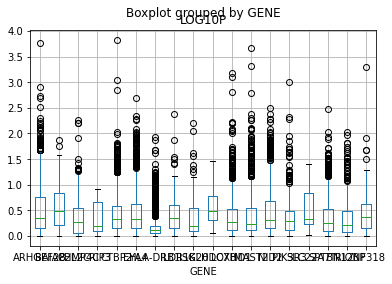

In [25]:
trait="f3393"
noise="f3393_f4825_1"
file = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/knowngenelist.txt"
knowngene = pd.read_csv(file,header=None,sep=" ")
statfile = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_"+trait+"/"+noise+"_interterm.slim.txt"
stat = pd.read_csv(statfile,header=0,sep="\t")
inter = pd.DataFrame(columns=['CHROM', 'GENPOS', 'ID', 'GENE', 'LOG10P'])
for i in range(0,knowngene.shape[0]):
    tmp = stat[stat["CHROM"]==knowngene.loc[i,1]]
    tmp = tmp[(tmp["GENPOS"]>=knowngene.loc[i,2])&(tmp["GENPOS"]<=knowngene.loc[i,3])]
    tmp["GENE"] =  knowngene.loc[i,0]
    tmp = tmp[['CHROM', 'GENPOS', 'ID', 'GENE', 'LOG10P']]
    inter = inter.append(tmp,ignore_index=True)
inter.boxplot("LOG10P",by='GENE')

<AxesSubplot:title={'center':'LOG10P'}, xlabel='GENE'>

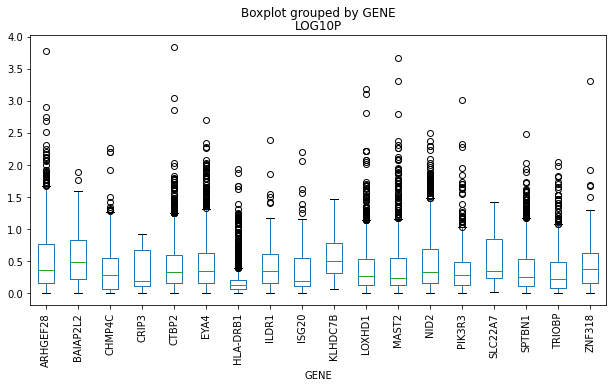

In [27]:
inter.boxplot("LOG10P",by='GENE',rot=90,grid=False,figsize=(10,5))

In [29]:
def boxplot(trait,noise):
    import pandas as pd
    file = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/knowngenelist.txt"
    knowngene = pd.read_csv(file,header=None,sep=" ")
    statfile = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_"+trait+"/"+noise+"_interterm.slim.txt"
    stat = pd.read_csv(statfile,header=0,sep="\t")
    inter = pd.DataFrame(columns=['CHROM', 'GENPOS', 'ID', 'GENE', 'P'])
    for i in range(0,knowngene.shape[0]):
        tmp = stat[stat["CHROM"]==knowngene.loc[i,1]]
        tmp = tmp[(tmp["GENPOS"]>=knowngene.loc[i,2])&(tmp["GENPOS"]<=knowngene.loc[i,3])]
        tmp["GENE"] =  knowngene.loc[i,0]
        tmp = tmp[['CHROM', 'GENPOS', 'ID', 'GENE', 'LOG10P']]
        inter = inter.append(tmp,ignore_index=True)
    inter.boxplot("LOG10P",by='GENE',rot=90,grid=False,figsize=(10,5))

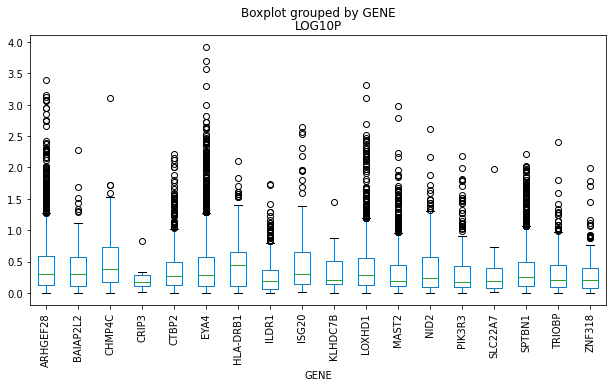

In [30]:
trait="f3393"
noise="f3393_f4825_1"
boxplot(trait,noise)

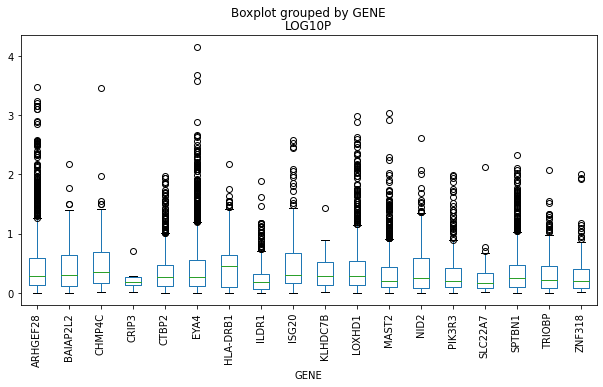

In [31]:
trait="f3393"
noise="f3393_f4825_2"
boxplot(trait,noise)

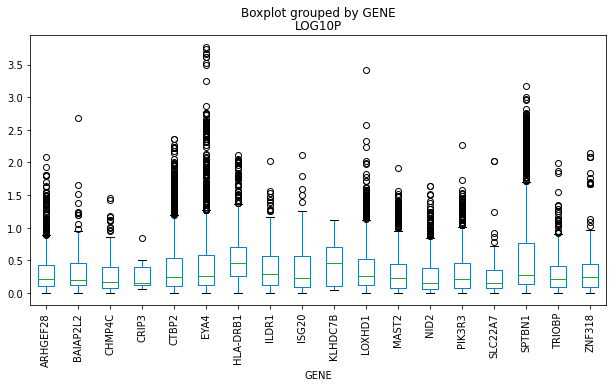

In [32]:
trait="f3393"
noise="f3393_f4836_1"
boxplot(trait,noise)

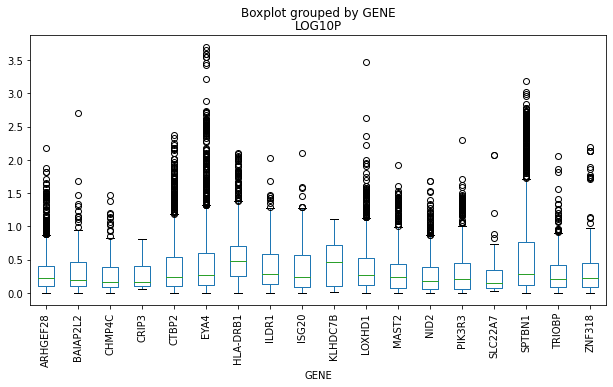

In [33]:
trait="f3393"
noise="f3393_f4836_2"
boxplot(trait,noise)

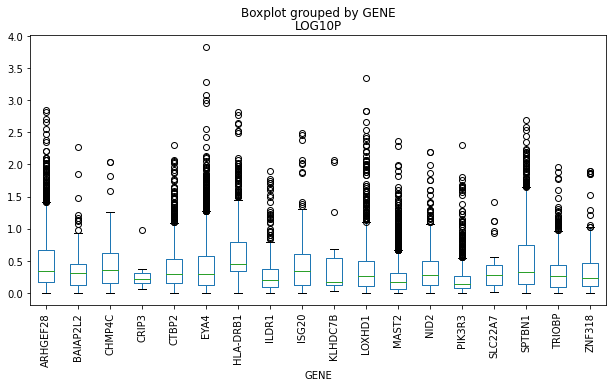

In [34]:
trait="f3393"
noise="f3393_f4825_f4836_1"
boxplot(trait,noise)

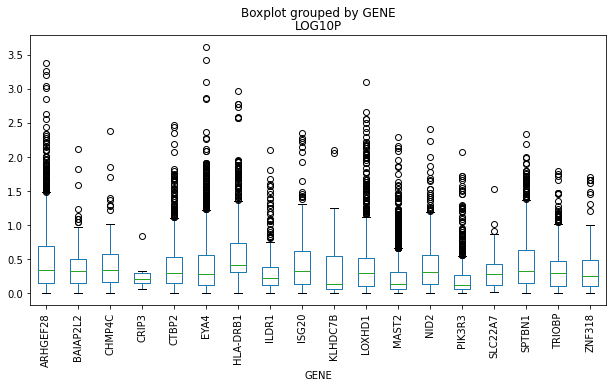

In [35]:
trait="f3393"
noise="f3393_f4825_f4836_2"
boxplot(trait,noise)

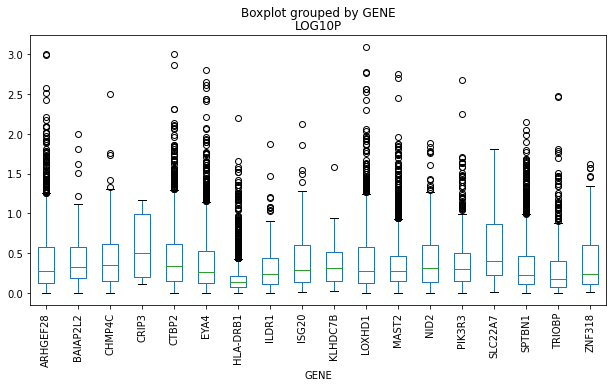

In [36]:
trait="f2247"
noise="f2247_f4825_1"
boxplot(trait,noise)

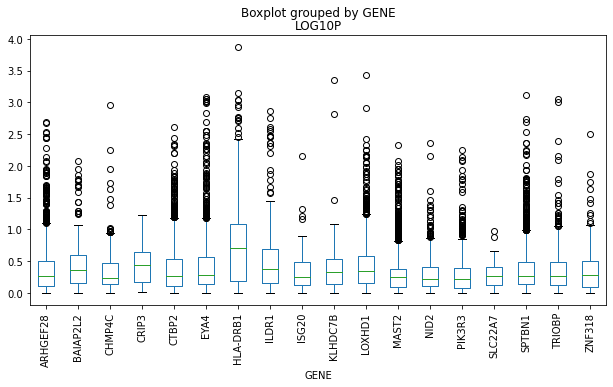

In [38]:
trait="f2247"
noise="f2247_f4836_1"
boxplot(trait,noise)

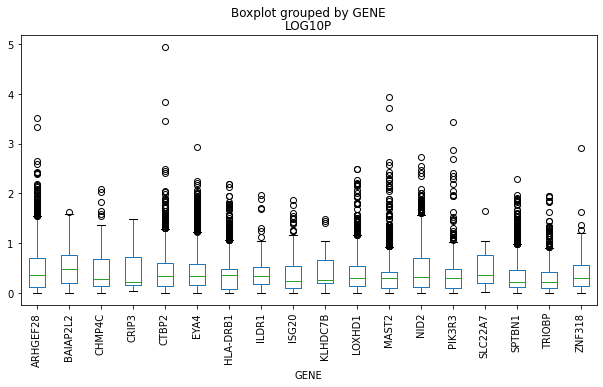

In [37]:
trait="f2247"
noise="f2247_f4825_f4836_1"
boxplot(trait,noise)

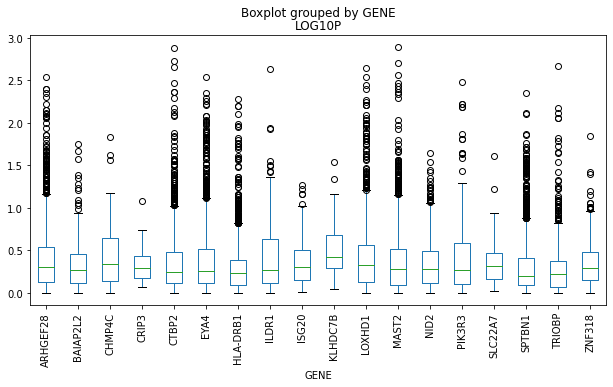

In [39]:
trait="f2257"
noise="f2257_f4825_1"
boxplot(trait,noise)

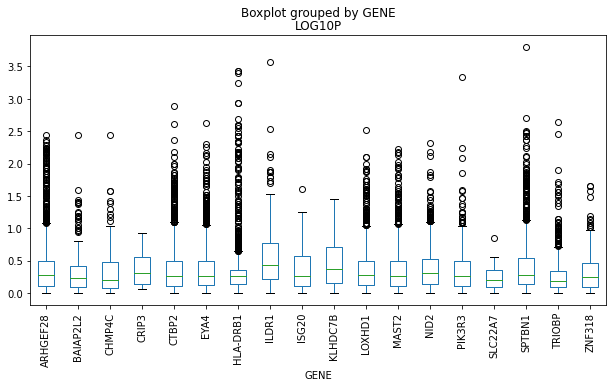

In [40]:
trait="f2257"
noise="f2257_f4836_1"
boxplot(trait,noise)

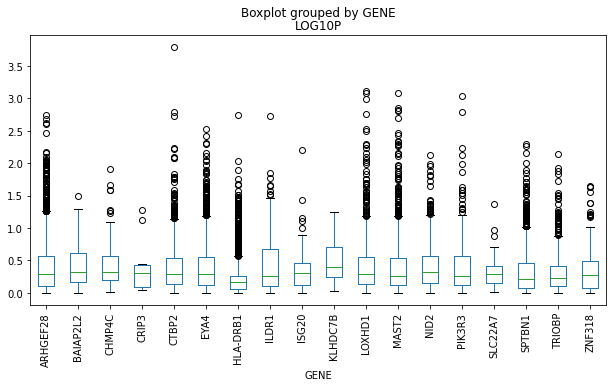

In [41]:
trait="f2257"
noise="f2257_f4825_f4836_1"
boxplot(trait,noise)

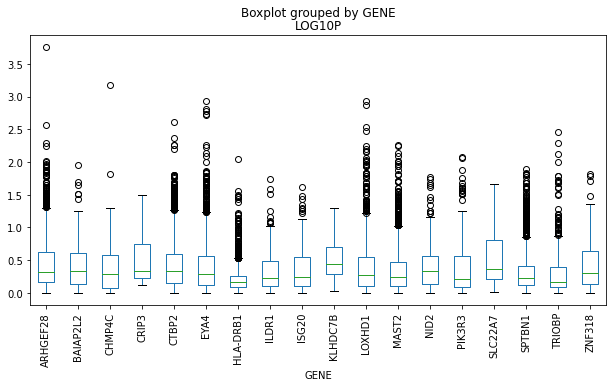

In [42]:
trait="f2247_f2257"
noise="f2247_f2257_f4825_1"
boxplot(trait,noise)

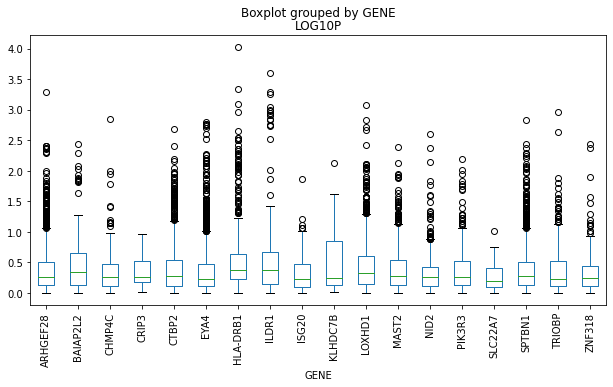

In [43]:
trait="f2247_f2257"
noise="f2247_f2257_f4836_1"
boxplot(trait,noise)

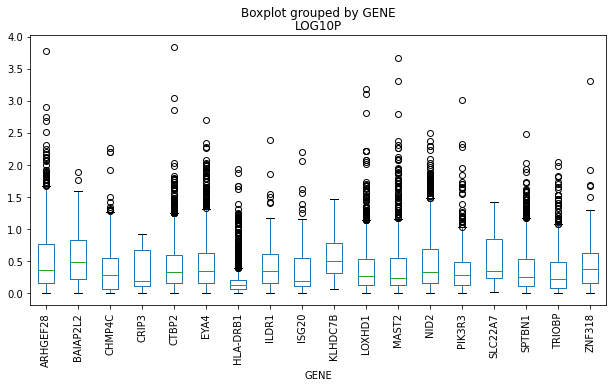

In [44]:
trait="f2247_f2257"
noise="f2247_f2257_f4825_f4836_1"
boxplot(trait,noise)

## Extract results for the known variants that has been replicated

In [2]:
import pandas as pd
file = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/knowngenevariants.txt"
knownvar = pd.read_csv(file,header=0,sep="\t")
knownvar

,Chrom,Pos hg19,gene,rsid
0,1,46239991,MAST2,rs12027345
1,1,46261604,MAST2,rs36089056
2,2,54794927,SPTBN1,rs9677089
3,2,54817683,SPTBN1,rs6545432
4,2,54834380,SPTBN1,rs6740893
5,2,54862003,SPTBN1,rs2941580
6,3,121712980,ILDR1,rs3915060
7,3,121715432,ILDR1,rs2332035
8,3,121993204,ILDR1,rs2877561
9,5,72915806,ARHGEF28,rs6890164


In [6]:
knownvar.shape

(44, 4)

In [18]:
trait="f3393"
noise="f3393_f4825_1"
statfile = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_"+trait+"/"+noise+"_interterm.slim.txt"
stat = pd.read_csv(statfile,header=0,sep="\t")
inter = pd.DataFrame(columns=['CHROM', 'GENPOS', 'ID', 'GENE', 'P'])
for i in range(0,knownvar.shape[0]):
    tmp = stat[stat["CHROM"]==knownvar.loc[i,"Chrom"]]
    tmp = tmp[(tmp["GENPOS"]==knownvar.loc[i,"Pos hg19"])]
    tmp["GENE"] =  knownvar.loc[i,"gene"]
    tmp = tmp[['CHROM', 'GENPOS', 'ID', 'GENE', 'LOG10P']]
    tmp["LOG10P"] = 10**(-tmp["LOG10P"])
    tmp = tmp.rename(columns={"LOG10P":"P"})
    inter = inter.append(tmp,ignore_index=True)
inter

,CHROM,GENPOS,ID,GENE,P
0,1,46239991,rs12027345,MAST2,0.326205
1,1,46261604,rs36089056,MAST2,0.252872
2,2,54794927,rs9677089,SPTBN1,0.662310
3,2,54817683,rs6545432,SPTBN1,0.351548
4,2,54834380,rs6740893,SPTBN1,0.816880
5,2,54862003,rs2941580,SPTBN1,0.481090
6,3,121712980,rs3915060,ILDR1,0.959775
7,3,121715432,rs2332035,ILDR1,0.870145
8,5,72915806,rs6890164,ARHGEF28,0.625958
9,5,72920029,rs1981809,ARHGEF28,0.959677


In [19]:
inter[inter["P"]<=(0.05/44)]

,CHROM,GENPOS,ID,GENE,P


In [20]:
trait="f3393"
noise="f3393_f4825_2"
statfile = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_"+trait+"/"+noise+"_interterm.slim.txt"
stat = pd.read_csv(statfile,header=0,sep="\t")
inter = pd.DataFrame(columns=['CHROM', 'GENPOS', 'ID', 'GENE', 'P'])
for i in range(0,knownvar.shape[0]):
    tmp = stat[stat["CHROM"]==knownvar.loc[i,"Chrom"]]
    tmp = tmp[(tmp["GENPOS"]==knownvar.loc[i,"Pos hg19"])]
    tmp["GENE"] =  knownvar.loc[i,"gene"]
    tmp = tmp[['CHROM', 'GENPOS', 'ID', 'GENE', 'LOG10P']]
    tmp["LOG10P"] = 10**(-tmp["LOG10P"])
    tmp = tmp.rename(columns={"LOG10P":"P"})
    inter = inter.append(tmp,ignore_index=True)
inter

,CHROM,GENPOS,ID,GENE,P
0,1,46239991,rs12027345,MAST2,0.387623
1,1,46261604,rs36089056,MAST2,0.312152
2,2,54794927,rs9677089,SPTBN1,0.978253
3,2,54817683,rs6545432,SPTBN1,0.262317
4,2,54834380,rs6740893,SPTBN1,0.838950
5,2,54862003,rs2941580,SPTBN1,0.351727
6,3,121712980,rs3915060,ILDR1,0.909388
7,3,121715432,rs2332035,ILDR1,0.997547
8,5,72915806,rs6890164,ARHGEF28,0.586749
9,5,72920029,rs1981809,ARHGEF28,0.904820


In [21]:
inter[inter["P"]<=(0.05/44)]

,CHROM,GENPOS,ID,GENE,P


In [22]:
trait="f3393"
noise="f3393_f4836_1"
statfile = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_"+trait+"/"+noise+"_interterm.slim.txt"
stat = pd.read_csv(statfile,header=0,sep="\t")
inter = pd.DataFrame(columns=['CHROM', 'GENPOS', 'ID', 'GENE', 'P'])
for i in range(0,knownvar.shape[0]):
    tmp = stat[stat["CHROM"]==knownvar.loc[i,"Chrom"]]
    tmp = tmp[(tmp["GENPOS"]==knownvar.loc[i,"Pos hg19"])]
    tmp["GENE"] =  knownvar.loc[i,"gene"]
    tmp = tmp[['CHROM', 'GENPOS', 'ID', 'GENE', 'LOG10P']]
    tmp["LOG10P"] = 10**(-tmp["LOG10P"])
    tmp = tmp.rename(columns={"LOG10P":"P"})
    inter = inter.append(tmp,ignore_index=True)
inter

,CHROM,GENPOS,ID,GENE,P
0,1,46239991,rs12027345,MAST2,0.129684
1,1,46261604,rs36089056,MAST2,0.314205
2,2,54794927,rs9677089,SPTBN1,0.003499
3,2,54817683,rs6545432,SPTBN1,0.256980
4,2,54834380,rs6740893,SPTBN1,0.001818
5,2,54862003,rs2941580,SPTBN1,0.337576
6,3,121712980,rs3915060,ILDR1,0.779277
7,3,121715432,rs2332035,ILDR1,0.773156
8,5,72915806,rs6890164,ARHGEF28,0.408762
9,5,72920029,rs1981809,ARHGEF28,0.446303


In [23]:
inter[inter["P"]<=(0.05/44)]

,CHROM,GENPOS,ID,GENE,P


In [24]:
trait="f3393"
noise="f3393_f4836_2"
statfile = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_"+trait+"/"+noise+"_interterm.slim.txt"
stat = pd.read_csv(statfile,header=0,sep="\t")
inter = pd.DataFrame(columns=['CHROM', 'GENPOS', 'ID', 'GENE', 'P'])
for i in range(0,knownvar.shape[0]):
    tmp = stat[stat["CHROM"]==knownvar.loc[i,"Chrom"]]
    tmp = tmp[(tmp["GENPOS"]==knownvar.loc[i,"Pos hg19"])]
    tmp["GENE"] =  knownvar.loc[i,"gene"]
    tmp = tmp[['CHROM', 'GENPOS', 'ID', 'GENE', 'LOG10P']]
    tmp["LOG10P"] = 10**(-tmp["LOG10P"])
    tmp = tmp.rename(columns={"LOG10P":"P"})
    inter = inter.append(tmp,ignore_index=True)
inter

,CHROM,GENPOS,ID,GENE,P
0,1,46239991,rs12027345,MAST2,0.123548
1,1,46261604,rs36089056,MAST2,0.305926
2,2,54794927,rs9677089,SPTBN1,0.003035
3,2,54817683,rs6545432,SPTBN1,0.253627
4,2,54834380,rs6740893,SPTBN1,0.001648
5,2,54862003,rs2941580,SPTBN1,0.332524
6,3,121712980,rs3915060,ILDR1,0.796360
7,3,121715432,rs2332035,ILDR1,0.791650
8,5,72915806,rs6890164,ARHGEF28,0.454150
9,5,72920029,rs1981809,ARHGEF28,0.480936


In [25]:
inter[inter["P"]<=(0.05/44)]

,CHROM,GENPOS,ID,GENE,P


In [26]:
trait="f3393"
noise="f3393_f4825_f4836_1"
statfile = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_"+trait+"/"+noise+"_interterm.slim.txt"
stat = pd.read_csv(statfile,header=0,sep="\t")
inter = pd.DataFrame(columns=['CHROM', 'GENPOS', 'ID', 'GENE', 'P'])
for i in range(0,knownvar.shape[0]):
    tmp = stat[stat["CHROM"]==knownvar.loc[i,"Chrom"]]
    tmp = tmp[(tmp["GENPOS"]==knownvar.loc[i,"Pos hg19"])]
    tmp["GENE"] =  knownvar.loc[i,"gene"]
    tmp = tmp[['CHROM', 'GENPOS', 'ID', 'GENE', 'LOG10P']]
    tmp["LOG10P"] = 10**(-tmp["LOG10P"])
    tmp = tmp.rename(columns={"LOG10P":"P"})
    inter = inter.append(tmp,ignore_index=True)
inter

,CHROM,GENPOS,ID,GENE,P
0,1,46239991,rs12027345,MAST2,0.773986
1,1,46261604,rs36089056,MAST2,0.584828
2,2,54794927,rs9677089,SPTBN1,0.032284
3,2,54817683,rs6545432,SPTBN1,0.902728
4,2,54834380,rs6740893,SPTBN1,0.061159
5,2,54862003,rs2941580,SPTBN1,0.821201
6,3,121712980,rs3915060,ILDR1,0.654193
7,3,121715432,rs2332035,ILDR1,0.702315
8,5,72915806,rs6890164,ARHGEF28,0.486582
9,5,72920029,rs1981809,ARHGEF28,0.806920


In [27]:
inter[inter["P"]<=(0.05/44)]

,CHROM,GENPOS,ID,GENE,P


In [28]:
trait="f3393"
noise="f3393_f4825_f4836_2"
statfile = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_"+trait+"/"+noise+"_interterm.slim.txt"
stat = pd.read_csv(statfile,header=0,sep="\t")
inter = pd.DataFrame(columns=['CHROM', 'GENPOS', 'ID', 'GENE', 'P'])
for i in range(0,knownvar.shape[0]):
    tmp = stat[stat["CHROM"]==knownvar.loc[i,"Chrom"]]
    tmp = tmp[(tmp["GENPOS"]==knownvar.loc[i,"Pos hg19"])]
    tmp["GENE"] =  knownvar.loc[i,"gene"]
    tmp = tmp[['CHROM', 'GENPOS', 'ID', 'GENE', 'LOG10P']]
    tmp["LOG10P"] = 10**(-tmp["LOG10P"])
    tmp = tmp.rename(columns={"LOG10P":"P"})
    inter = inter.append(tmp,ignore_index=True)
inter

,CHROM,GENPOS,ID,GENE,P
0,1,46239991,rs12027345,MAST2,0.973523
1,1,46261604,rs36089056,MAST2,0.783590
2,2,54794927,rs9677089,SPTBN1,0.104305
3,2,54817683,rs6545432,SPTBN1,0.895221
4,2,54834380,rs6740893,SPTBN1,0.192717
5,2,54862003,rs2941580,SPTBN1,0.965349
6,3,121712980,rs3915060,ILDR1,0.557709
7,3,121715432,rs2332035,ILDR1,0.612757
8,5,72915806,rs6890164,ARHGEF28,0.583244
9,5,72920029,rs1981809,ARHGEF28,0.882981


In [29]:
inter[inter["P"]<=(0.05/44)]

,CHROM,GENPOS,ID,GENE,P


In [30]:
trait="f2247"
noise="f2247_f4825_1"
statfile = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_"+trait+"/"+noise+"_interterm.slim.txt"
stat = pd.read_csv(statfile,header=0,sep="\t")
inter = pd.DataFrame(columns=['CHROM', 'GENPOS', 'ID', 'GENE', 'P'])
for i in range(0,knownvar.shape[0]):
    tmp = stat[stat["CHROM"]==knownvar.loc[i,"Chrom"]]
    tmp = tmp[(tmp["GENPOS"]==knownvar.loc[i,"Pos hg19"])]
    tmp["GENE"] =  knownvar.loc[i,"gene"]
    tmp = tmp[['CHROM', 'GENPOS', 'ID', 'GENE', 'LOG10P']]
    tmp["LOG10P"] = 10**(-tmp["LOG10P"])
    tmp = tmp.rename(columns={"LOG10P":"P"})
    inter = inter.append(tmp,ignore_index=True)
inter

,CHROM,GENPOS,ID,GENE,P
0,1,46239991,rs12027345,MAST2,0.612304
1,1,46261604,rs36089056,MAST2,0.517304
2,2,54794927,rs9677089,SPTBN1,0.881813
3,2,54817683,rs6545432,SPTBN1,0.587977
4,2,54834380,rs6740893,SPTBN1,0.766664
5,2,54862003,rs2941580,SPTBN1,0.909543
6,3,121712980,rs3915060,ILDR1,0.751339
7,3,121715432,rs2332035,ILDR1,0.780119
8,5,72915806,rs6890164,ARHGEF28,0.453514
9,5,72920029,rs1981809,ARHGEF28,0.478653


In [31]:
inter[inter["P"]<=(0.05/44)]

,CHROM,GENPOS,ID,GENE,P


In [32]:
trait="f2247"
noise="f2247_f4836_1"
statfile = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_"+trait+"/"+noise+"_interterm.slim.txt"
stat = pd.read_csv(statfile,header=0,sep="\t")
inter = pd.DataFrame(columns=['CHROM', 'GENPOS', 'ID', 'GENE', 'P'])
for i in range(0,knownvar.shape[0]):
    tmp = stat[stat["CHROM"]==knownvar.loc[i,"Chrom"]]
    tmp = tmp[(tmp["GENPOS"]==knownvar.loc[i,"Pos hg19"])]
    tmp["GENE"] =  knownvar.loc[i,"gene"]
    tmp = tmp[['CHROM', 'GENPOS', 'ID', 'GENE', 'LOG10P']]
    tmp["LOG10P"] = 10**(-tmp["LOG10P"])
    tmp = tmp.rename(columns={"LOG10P":"P"})
    inter = inter.append(tmp,ignore_index=True)
inter

,CHROM,GENPOS,ID,GENE,P
0,1,46239991,rs12027345,MAST2,0.417906
1,1,46261604,rs36089056,MAST2,0.414941
2,2,54794927,rs9677089,SPTBN1,0.454984
3,2,54817683,rs6545432,SPTBN1,0.511026
4,2,54834380,rs6740893,SPTBN1,0.370491
5,2,54862003,rs2941580,SPTBN1,0.489220
6,3,121712980,rs3915060,ILDR1,0.439415
7,3,121715432,rs2332035,ILDR1,0.327654
8,5,72915806,rs6890164,ARHGEF28,0.725660
9,5,72920029,rs1981809,ARHGEF28,0.844178


In [33]:
inter[inter["P"]<=(0.05/44)]

,CHROM,GENPOS,ID,GENE,P


In [34]:
trait="f2247"
noise="f2247_f4825_f4836_1"
statfile = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_"+trait+"/"+noise+"_interterm.slim.txt"
stat = pd.read_csv(statfile,header=0,sep="\t")
inter = pd.DataFrame(columns=['CHROM', 'GENPOS', 'ID', 'GENE', 'P'])
for i in range(0,knownvar.shape[0]):
    tmp = stat[stat["CHROM"]==knownvar.loc[i,"Chrom"]]
    tmp = tmp[(tmp["GENPOS"]==knownvar.loc[i,"Pos hg19"])]
    tmp["GENE"] =  knownvar.loc[i,"gene"]
    tmp = tmp[['CHROM', 'GENPOS', 'ID', 'GENE', 'LOG10P']]
    tmp["LOG10P"] = 10**(-tmp["LOG10P"])
    tmp = tmp.rename(columns={"LOG10P":"P"})
    inter = inter.append(tmp,ignore_index=True)
inter

,CHROM,GENPOS,ID,GENE,P
0,1,46239991,rs12027345,MAST2,0.455806
1,1,46261604,rs36089056,MAST2,0.401489
2,2,54794927,rs9677089,SPTBN1,0.668659
3,2,54817683,rs6545432,SPTBN1,0.509609
4,2,54834380,rs6740893,SPTBN1,0.589629
5,2,54862003,rs2941580,SPTBN1,0.910373
6,3,121712980,rs3915060,ILDR1,0.437720
7,3,121715432,rs2332035,ILDR1,0.357167
8,5,72915806,rs6890164,ARHGEF28,0.973472
9,5,72920029,rs1981809,ARHGEF28,0.941050


In [35]:
inter[inter["P"]<=(0.05/44)]

,CHROM,GENPOS,ID,GENE,P


In [36]:
trait="f2257"
noise="f2257_f4825_1"
statfile = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_"+trait+"/"+noise+"_interterm.slim.txt"
stat = pd.read_csv(statfile,header=0,sep="\t")
inter = pd.DataFrame(columns=['CHROM', 'GENPOS', 'ID', 'GENE', 'P'])
for i in range(0,knownvar.shape[0]):
    tmp = stat[stat["CHROM"]==knownvar.loc[i,"Chrom"]]
    tmp = tmp[(tmp["GENPOS"]==knownvar.loc[i,"Pos hg19"])]
    tmp["GENE"] =  knownvar.loc[i,"gene"]
    tmp = tmp[['CHROM', 'GENPOS', 'ID', 'GENE', 'LOG10P']]
    tmp["LOG10P"] = 10**(-tmp["LOG10P"])
    tmp = tmp.rename(columns={"LOG10P":"P"})
    inter = inter.append(tmp,ignore_index=True)
inter

,CHROM,GENPOS,ID,GENE,P
0,1,46239991,rs12027345,MAST2,0.424983
1,1,46261604,rs36089056,MAST2,0.282776
2,2,54794927,rs9677089,SPTBN1,0.704043
3,2,54817683,rs6545432,SPTBN1,0.910736
4,2,54834380,rs6740893,SPTBN1,0.649039
5,2,54862003,rs2941580,SPTBN1,0.578366
6,3,121712980,rs3915060,ILDR1,0.345913
7,3,121715432,rs2332035,ILDR1,0.364250
8,5,72915806,rs6890164,ARHGEF28,0.661569
9,5,72920029,rs1981809,ARHGEF28,0.409325


In [37]:
inter[inter["P"]<=(0.05/44)]

,CHROM,GENPOS,ID,GENE,P


In [38]:
trait="f2257"
noise="f2257_f4836_1"
statfile = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_"+trait+"/"+noise+"_interterm.slim.txt"
stat = pd.read_csv(statfile,header=0,sep="\t")
inter = pd.DataFrame(columns=['CHROM', 'GENPOS', 'ID', 'GENE', 'P'])
for i in range(0,knownvar.shape[0]):
    tmp = stat[stat["CHROM"]==knownvar.loc[i,"Chrom"]]
    tmp = tmp[(tmp["GENPOS"]==knownvar.loc[i,"Pos hg19"])]
    tmp["GENE"] =  knownvar.loc[i,"gene"]
    tmp = tmp[['CHROM', 'GENPOS', 'ID', 'GENE', 'LOG10P']]
    tmp["LOG10P"] = 10**(-tmp["LOG10P"])
    tmp = tmp.rename(columns={"LOG10P":"P"})
    inter = inter.append(tmp,ignore_index=True)
inter

,CHROM,GENPOS,ID,GENE,P
0,1,46239991,rs12027345,MAST2,0.314576
1,1,46261604,rs36089056,MAST2,0.359560
2,2,54794927,rs9677089,SPTBN1,0.737722
3,2,54817683,rs6545432,SPTBN1,0.397728
4,2,54834380,rs6740893,SPTBN1,0.631427
5,2,54862003,rs2941580,SPTBN1,0.500450
6,3,121712980,rs3915060,ILDR1,0.345619
7,3,121715432,rs2332035,ILDR1,0.245681
8,5,72915806,rs6890164,ARHGEF28,0.278458
9,5,72920029,rs1981809,ARHGEF28,0.463925


In [39]:
inter[inter["P"]<=(0.05/44)]

,CHROM,GENPOS,ID,GENE,P


In [40]:
trait="f2257"
noise="f2257_f4825_f4836_1"
statfile = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_"+trait+"/"+noise+"_interterm.slim.txt"
stat = pd.read_csv(statfile,header=0,sep="\t")
inter = pd.DataFrame(columns=['CHROM', 'GENPOS', 'ID', 'GENE', 'P'])
for i in range(0,knownvar.shape[0]):
    tmp = stat[stat["CHROM"]==knownvar.loc[i,"Chrom"]]
    tmp = tmp[(tmp["GENPOS"]==knownvar.loc[i,"Pos hg19"])]
    tmp["GENE"] =  knownvar.loc[i,"gene"]
    tmp = tmp[['CHROM', 'GENPOS', 'ID', 'GENE', 'LOG10P']]
    tmp["LOG10P"] = 10**(-tmp["LOG10P"])
    tmp = tmp.rename(columns={"LOG10P":"P"})
    inter = inter.append(tmp,ignore_index=True)
inter

,CHROM,GENPOS,ID,GENE,P
0,1,46239991,rs12027345,MAST2,0.251176
1,1,46261604,rs36089056,MAST2,0.197337
2,2,54794927,rs9677089,SPTBN1,0.707819
3,2,54817683,rs6545432,SPTBN1,0.975679
4,2,54834380,rs6740893,SPTBN1,0.772686
5,2,54862003,rs2941580,SPTBN1,0.671030
6,3,121712980,rs3915060,ILDR1,0.931180
7,3,121715432,rs2332035,ILDR1,0.798017
8,5,72915806,rs6890164,ARHGEF28,0.810473
9,5,72920029,rs1981809,ARHGEF28,0.859571


In [41]:
inter[inter["P"]<=(0.05/44)]

,CHROM,GENPOS,ID,GENE,P


In [42]:
trait="f2247_f2257"
noise="f2247_f2257_f4825_1"
statfile = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_"+trait+"/"+noise+"_interterm.slim.txt"
stat = pd.read_csv(statfile,header=0,sep="\t")
inter = pd.DataFrame(columns=['CHROM', 'GENPOS', 'ID', 'GENE', 'P'])
for i in range(0,knownvar.shape[0]):
    tmp = stat[stat["CHROM"]==knownvar.loc[i,"Chrom"]]
    tmp = tmp[(tmp["GENPOS"]==knownvar.loc[i,"Pos hg19"])]
    tmp["GENE"] =  knownvar.loc[i,"gene"]
    tmp = tmp[['CHROM', 'GENPOS', 'ID', 'GENE', 'LOG10P']]
    tmp["LOG10P"] = 10**(-tmp["LOG10P"])
    tmp = tmp.rename(columns={"LOG10P":"P"})
    inter = inter.append(tmp,ignore_index=True)
inter

,CHROM,GENPOS,ID,GENE,P
0,1,46239991,rs12027345,MAST2,0.411071
1,1,46261604,rs36089056,MAST2,0.335245
2,2,54794927,rs9677089,SPTBN1,0.757039
3,2,54817683,rs6545432,SPTBN1,0.543427
4,2,54834380,rs6740893,SPTBN1,0.775772
5,2,54862003,rs2941580,SPTBN1,0.920617
6,3,121712980,rs3915060,ILDR1,0.560070
7,3,121715432,rs2332035,ILDR1,0.599581
8,5,72915806,rs6890164,ARHGEF28,0.370858
9,5,72920029,rs1981809,ARHGEF28,0.337928


In [43]:
inter[inter["P"]<=(0.05/44)]

,CHROM,GENPOS,ID,GENE,P


In [44]:
trait="f2247_f2257"
noise="f2247_f2257_f4836_1"
statfile = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_"+trait+"/"+noise+"_interterm.slim.txt"
stat = pd.read_csv(statfile,header=0,sep="\t")
inter = pd.DataFrame(columns=['CHROM', 'GENPOS', 'ID', 'GENE', 'P'])
for i in range(0,knownvar.shape[0]):
    tmp = stat[stat["CHROM"]==knownvar.loc[i,"Chrom"]]
    tmp = tmp[(tmp["GENPOS"]==knownvar.loc[i,"Pos hg19"])]
    tmp["GENE"] =  knownvar.loc[i,"gene"]
    tmp = tmp[['CHROM', 'GENPOS', 'ID', 'GENE', 'LOG10P']]
    tmp["LOG10P"] = 10**(-tmp["LOG10P"])
    tmp = tmp.rename(columns={"LOG10P":"P"})
    inter = inter.append(tmp,ignore_index=True)
inter

,CHROM,GENPOS,ID,GENE,P
0,1,46239991,rs12027345,MAST2,0.343555
1,1,46261604,rs36089056,MAST2,0.356117
2,2,54794927,rs9677089,SPTBN1,0.675767
3,2,54817683,rs6545432,SPTBN1,0.491309
4,2,54834380,rs6740893,SPTBN1,0.583121
5,2,54862003,rs2941580,SPTBN1,0.530098
6,3,121712980,rs3915060,ILDR1,0.537052
7,3,121715432,rs2332035,ILDR1,0.387313
8,5,72915806,rs6890164,ARHGEF28,0.647433
9,5,72920029,rs1981809,ARHGEF28,0.808570


In [45]:
inter[inter["P"]<=(0.05/44)]

,CHROM,GENPOS,ID,GENE,P


In [46]:
trait="f2247_f2257"
noise="f2247_f2257_f4825_f4836_1"
statfile = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/2022_02_18_"+trait+"/"+noise+"_interterm.slim.txt"
stat = pd.read_csv(statfile,header=0,sep="\t")
inter = pd.DataFrame(columns=['CHROM', 'GENPOS', 'ID', 'GENE', 'P'])
for i in range(0,knownvar.shape[0]):
    tmp = stat[stat["CHROM"]==knownvar.loc[i,"Chrom"]]
    tmp = tmp[(tmp["GENPOS"]==knownvar.loc[i,"Pos hg19"])]
    tmp["GENE"] =  knownvar.loc[i,"gene"]
    tmp = tmp[['CHROM', 'GENPOS', 'ID', 'GENE', 'LOG10P']]
    tmp["LOG10P"] = 10**(-tmp["LOG10P"])
    tmp = tmp.rename(columns={"LOG10P":"P"})
    inter = inter.append(tmp,ignore_index=True)
inter

,CHROM,GENPOS,ID,GENE,P
0,1,46239991,rs12027345,MAST2,0.260117
1,1,46261604,rs36089056,MAST2,0.235381
2,2,54794927,rs9677089,SPTBN1,0.783702
3,2,54817683,rs6545432,SPTBN1,0.453907
4,2,54834380,rs6740893,SPTBN1,0.781302
5,2,54862003,rs2941580,SPTBN1,0.741927
6,3,121712980,rs3915060,ILDR1,0.622247
7,3,121715432,rs2332035,ILDR1,0.486623
8,5,72915806,rs6890164,ARHGEF28,0.899452
9,5,72920029,rs1981809,ARHGEF28,0.857229


In [47]:
inter[inter["P"]<=(0.05/44)]

,CHROM,GENPOS,ID,GENE,P


## Check the main effects of known variants

In [1]:
import pandas as pd
file = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/knowngenevariants.txt"
knownvar = pd.read_csv(file,header=0,sep="\t")
knownvar

Traceback (most recent call last):
  File "/home/gl2776/miniconda3/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/gl2776/miniconda3/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/home/gl2776/miniconda3/lib/python3.8/site-packages/ipykernel_launcher.py", line 15, in <module>
    from ipykernel import kernelapp as app
  File "/home/gl2776/miniconda3/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 18, in <module>
    from IPython.core.application import (
  File "/home/gl2776/miniconda3/lib/python3.8/site-packages/IPython/__init__.py", line 53, in <module>
    from .terminal.embed import embed
  File "/home/gl2776/miniconda3/lib/python3.8/site-packages/IPython/terminal/embed.py", line 16, in <module>
    from IPython.terminal.interactiveshell import TerminalInteractiveShell
  File "/home/gl2776/miniconda3/lib/python3.8/site-packages/IPython/terminal/interactiveshell.py", 

,Chrom,Pos hg19,gene,rsid
0,1,46239991,MAST2,rs12027345
1,1,46261604,MAST2,rs36089056
2,2,54794927,SPTBN1,rs9677089
3,2,54817683,SPTBN1,rs6545432
4,2,54834380,SPTBN1,rs6740893
5,2,54862003,SPTBN1,rs2941580
6,3,121712980,ILDR1,rs3915060
7,3,121715432,ILDR1,rs2332035
8,3,121993204,ILDR1,rs2877561
9,5,72915806,ARHGEF28,rs6890164


In [2]:
file = "~/project/guangyou/imputation/genome/genome_20220310/imputed/UKB_imputed_chr1_mac1_minmaf1e-06.bim"
bim = pd.read_csv(file,header=None,sep="\t")
bim

,0,1,2,3,4,5
0,1,rs367896724,0,10177,AC,A
1,1,rs201106462,0,10352,TA,T
2,1,rs534229142,0,10511,A,G
3,1,rs537182016,0,10539,A,C
4,1,1:10616_CCGCCGTTGCAAAGGCGCGCCG_C,0,10616,CCGCCGTTGCAAAGGCGCGCCG,C
...,...,...,...,...,...,...
4859603,1,rs541756783,0,249240099,T,TA
4859604,1,rs370070114,0,249240219,T,A
4859605,1,1:249240537_GGT_G,0,249240537,G,GGT
4859606,1,rs545682552,0,249240539,G,T


In [5]:
knownvar.loc[knownvar["Chrom"]==1,"Pos hg19"]

0     46239991
1     46261604
42    46261604
Name: Pos hg19, dtype: int64

In [19]:
bim[bim[3].isin(knownvar.loc[knownvar["Chrom"]==1,"Pos hg19"].to_list())]

,0,1,2,3,4,5
1021844,1,rs12027345,0,46239991,A,G
1022313,1,rs36089056,0,46261604,TA,T


In [3]:
snp = pd.DataFrame(columns=[0,1,2,3,4,5])
for i in range(1,23):
    file = "~/project/guangyou/imputation/genome/genome_20220310/imputed/UKB_imputed_chr"+str(i)+"_mac1_minmaf1e-06.bim"
    bim = pd.read_csv(file,header=None,sep="\t")
    snp = pd.concat([snp,bim[bim[3].isin(knownvar.loc[knownvar["Chrom"]==i,"Pos hg19"].to_list())]], axis=0,ignore_index=True)
snp

,0,1,2,3,4,5
0,1,rs12027345,0,46239991,A,G
1,1,rs36089056,0,46261604,TA,T
2,2,rs9677089,0,54794927,C,A
3,2,rs6545432,0,54817683,G,A
4,2,rs6740893,0,54834380,A,G
5,2,rs2941580,0,54862003,A,G
6,3,rs3915060,0,121712980,C,T
7,3,rs2332035,0,121715432,T,C
8,5,rs6890164,0,72915806,G,A
9,5,rs1981809,0,72920029,T,C


In [4]:
knownvar = knownvar.merge(snp,how="left",left_on="Pos hg19",right_on=3)
knownvar = knownvar.drop(index=42,columns=[0,1,2,3])
knownvar = knownvar.sort_values(by=['Chrom', 'Pos hg19'])
knownvar

,Chrom,Pos hg19,gene,rsid,4,5
0,1,46239991,MAST2,rs12027345,A,G
1,1,46261604,MAST2,rs36089056,TA,T
2,2,54794927,SPTBN1,rs9677089,C,A
3,2,54817683,SPTBN1,rs6545432,G,A
4,2,54834380,SPTBN1,rs6740893,A,G
5,2,54862003,SPTBN1,rs2941580,A,G
6,3,121712980,ILDR1,rs3915060,C,T
7,3,121715432,ILDR1,rs2332035,T,C
8,3,121993204,ILDR1,rs2877561,NaN,NaN
9,5,72915806,ARHGEF28,rs6890164,G,A


In [5]:
# Find some variants are in hg38, or deletion or insertion
## Modify them to hg19 according to NCBI
knownvar.loc[knownvar["rsid"]=="rs2877561","Pos hg19"]=121712051
knownvar.loc[knownvar["rsid"]=="rs2877561",4]="C"
knownvar.loc[knownvar["rsid"]=="rs2877561",5]="A"
knownvar.loc[knownvar["rsid"]=="rs201291779","Pos hg19"]=32561374
knownvar.loc[knownvar["rsid"]=="rs201291779",4]="G"
knownvar.loc[knownvar["rsid"]=="rs201291779",5]="GG"
knownvar.loc[knownvar["rsid"]=="rs137960856","Pos hg19"]=82665476
knownvar.loc[knownvar["rsid"]=="rs137960856",4]="GTGA"
knownvar.loc[knownvar["rsid"]=="rs137960856",5]="GTGAGTGA"
knownvar.loc[knownvar["rsid"]=="rs58389158","Pos hg19"]=38128283
knownvar.loc[knownvar["rsid"]=="rs58389158",4]="T"
knownvar.loc[knownvar["rsid"]=="rs58389158",5]="TA"
knownvar.loc[knownvar["rsid"]=="rs132924","Pos hg19"]=38483156
knownvar.loc[knownvar["rsid"]=="rs132924",4]="TCATGGGTGTCATGGGTGTCATGGG"
knownvar.loc[knownvar["rsid"]=="rs132924",5]="TCATGGGTGTCATGGG"
knownvar.loc[knownvar["rsid"]=="rs749405486","Pos hg19"]=50987496
knownvar.loc[knownvar["rsid"]=="rs749405486",4]="GGG"
knownvar.loc[knownvar["rsid"]=="rs749405486",5]="GGGG"

In [6]:
from liftover import get_lifter
chainmap = get_lifter('hg19', 'hg38')
def bim_liftover(bim,chainmap):
    new_bim = []
    #bim=pd.read_csv(bim,names=['chrom','snp','cm','pos','a0','a1'],header=None,sep="\t")
    for c,p,a0,a1 in zip(bim.chrom,bim.pos,bim.a0,bim.a1):
        if chainmap[int(c)][p]==[]:
            new_c, new_p = 0, 0
            snp = ':'.join([str(new_c),str(new_p),a1,a0])
            new_bim.append([int(new_c),snp,new_p,a0,a1])            
        else:
            new_c,new_p,_ = chainmap[int(c)][p][0]
            if len(str(new_c))>=6:
                new_c, new_p = 0, 0
                snp = ':'.join([str(new_c),str(new_p),a1,a0])
                new_bim.append([int(new_c),snp,new_p,a0,a1])
            elif "X" in str(new_c) or "Y" in str(new_c):
                new_c, new_p = 0, 0
                snp = ':'.join([str(new_c),str(new_p),a1,a0])
                new_bim.append([int(new_c),snp,new_p,a0,a1])
            else:
                snp = ':'.join([str(new_c),str(new_p),a1,a0])
                new_bim.append([int(new_c[3:]),snp,new_p,a0,a1])
    new_bim = pd.DataFrame(new_bim,columns=['chrom','snp','pos','a0','a1'])
    return new_bim

In [7]:
bim = knownvar.rename(columns={"Chrom":'chrom',"rsid":'snp',"Pos hg19":'pos',4:'a0',5:'a1'})
bim[['snp','a0','a1']] = bim[['snp','a0','a1']].astype("string")
new_bim = bim_liftover(bim,chainmap)
new_bim

,chrom,snp,pos,a0,a1
0,1,chr1:45774319:G:A,45774319,A,G
1,1,chr1:45795932:T:TA,45795932,TA,T
2,2,chr2:54567790:A:C,54567790,C,A
3,2,chr2:54590546:A:G,54590546,G,A
4,2,chr2:54607243:G:A,54607243,A,G
5,2,chr2:54634866:G:A,54634866,A,G
6,3,chr3:121994133:T:C,121994133,C,T
7,3,chr3:121996585:C:T,121996585,T,C
8,3,chr3:121993204:A:C,121993204,C,A
9,5,chr5:73619981:A:G,73619981,G,A


In [8]:
knownvar = pd.concat([knownvar.reset_index(),new_bim.reset_index()["snp"]], axis=1,ignore_index=True)
knownvar = knownvar.drop([0],axis=1)
knownvar = knownvar.rename(columns={1:"chrom",2:"pos",3:"gene",4:"rsid",5:"a1",6:"a0",7:"varID_hg38"})
knownvar = knownvar.astype("string")
knownvar["varID_hg19"] = knownvar["chrom"].str.cat(others=[knownvar["pos"],knownvar["a0"],knownvar["a1"]],sep=":")
knownvar

,chrom,pos,gene,rsid,a1,a0,varID_hg38,varID_hg19
0,1,46239991,MAST2,rs12027345,A,G,chr1:45774319:G:A,1:46239991:G:A
1,1,46261604,MAST2,rs36089056,TA,T,chr1:45795932:T:TA,1:46261604:T:TA
2,2,54794927,SPTBN1,rs9677089,C,A,chr2:54567790:A:C,2:54794927:A:C
3,2,54817683,SPTBN1,rs6545432,G,A,chr2:54590546:A:G,2:54817683:A:G
4,2,54834380,SPTBN1,rs6740893,A,G,chr2:54607243:G:A,2:54834380:G:A
5,2,54862003,SPTBN1,rs2941580,A,G,chr2:54634866:G:A,2:54862003:G:A
6,3,121712980,ILDR1,rs3915060,C,T,chr3:121994133:T:C,3:121712980:T:C
7,3,121715432,ILDR1,rs2332035,T,C,chr3:121996585:C:T,3:121715432:C:T
8,3,121712051,ILDR1,rs2877561,C,A,chr3:121993204:A:C,3:121712051:A:C
9,5,72915806,ARHGEF28,rs6890164,G,A,chr5:73619981:A:G,5:72915806:A:G


In [10]:
tmp = knownvar["varID_hg38"].str.split(":",expand=True)
knownvar["varID_hg38_flip"] = tmp[0].str.cat(others=[tmp[1],tmp[3],tmp[2]],sep=":")

In [12]:
file = "~/UKBiobank/results/REGENIE_results/results_exome_data/090921_f3393_hearing_aid_200K/090321_UKBB_Hearing_aid_f3393_expandedwhite_6436cases_96601ctrl_PC1_2_f3393.regenie.snp_stats.gz"
stat = pd.read_csv(file,header=0,sep="\t")
stat

,CHR,POS,REF,ALT,SNP,BETA,SE,P
0,1,925862,G,A,chr1:925862:G:A,-1.425140,1.279590,0.265390
1,1,925881,G,A,chr1:925881:G:A,-0.236930,0.142267,0.095834
2,1,925885,C,T,chr1:925885:C:T,-1.065500,2.232200,0.633124
3,1,925908,G,GGCTCT,chr1:925908:G:GGCTCT,1.601750,1.651090,0.331988
4,1,925915,C,T,chr1:925915:C:T,0.865111,1.417950,0.541786
...,...,...,...,...,...,...,...,...
3029148,22,50782235,G,A,chr22:50782235:G:A,-0.047169,1.037140,0.963725
3029149,22,50782243,C,T,chr22:50782243:C:T,-0.370907,0.289747,0.200508
3029150,22,50782271,C,T,chr22:50782271:C:T,-1.107710,1.056710,0.294517
3029151,22,50782306,T,C,chr22:50782306:T:C,-0.065070,0.119555,0.586258


In [13]:
stat[stat["SNP"].isin(knownvar["varID_hg38"].to_list())]

,CHR,POS,REF,ALT,SNP,BETA,SE,P
628564,3,121993204,A,C,chr3:121993204:A:C,-0.106138,0.021282,7.175299e-07
1054526,6,133468590,G,A,chr6:133468590:G:A,0.081244,0.020436,7.490486e-05
2580205,18,46557437,C,T,chr18:46557437:C:T,0.187800,0.062843,3.413972e-03
2993646,22,37726115,T,C,chr22:37726115:T:C,0.066294,0.019335,6.132252e-04
2993738,22,37735350,G,T,chr22:37735350:G:T,0.172335,0.439584,6.950275e-01
2995617,22,38089533,A,G,chr22:38089533:A:G,0.083489,0.019407,1.759057e-05
3027568,22,50549676,G,A,chr22:50549676:G:A,0.073553,0.047946,1.250098e-01


In [15]:
stat[stat["SNP"].isin(knownvar["varID_hg38_flip"].to_list())]

,CHR,POS,REF,ALT,SNP,BETA,SE,P
628636,3,121994133,C,T,chr3:121994133:C:T,-0.110007,0.021266,2.746313e-07
849066,5,73780686,C,A,chr5:73780686:C:A,0.111361,0.019242,7.300792e-09
2993665,22,37726455,A,G,chr22:37726455:A:G,0.065565,0.022064,2.858249e-03


In [16]:
snplist = pd.read_csv("~/UKBiobank/results/REGENIE_results/results_exome_data/051722_interaction_sex/vairants_of_interest.txt",header=None)[0].to_list()
stat[stat["SNP"].isin(snplist)]

,CHR,POS,REF,ALT,SNP,BETA,SE,P
111638,1,46001049,T,C,chr1:46001049:T:C,-0.042723,0.020191,3.424049e-02
111682,1,46021880,G,A,chr1:46021880:G:A,-0.042960,0.019634,2.857854e-02
111751,1,46027788,T,G,chr1:46027788:T:G,-0.038637,0.019406,4.637778e-02
112106,1,46132597,C,A,chr1:46132597:C:A,-0.039037,0.019407,4.417840e-02
811354,5,272741,A,G,chr5:272741:A:G,1.789340,0.250526,7.055048e-11
811355,5,272748,G,C,chr5:272748:G:C,1.698750,0.279645,2.479648e-08
811356,5,272755,A,G,chr5:272755:A:G,1.708990,0.242533,1.335826e-10
849046,5,73776529,T,C,chr5:73776529:T:C,0.110401,0.019235,9.986884e-09
849062,5,73780632,G,A,chr5:73780632:G:A,0.106506,0.019347,3.872398e-08
849063,5,73780649,GT,G,chr5:73780649:GT:G,0.112679,0.019433,7.029914e-09


In [73]:
result = knownvar.merge(stat[["SNP","P"]], how="left",left_on="varID_hg38",right_on="SNP")
result = result.drop(["SNP"],axis=1)
result = result.rename(columns={"P":"f3393"})
result

,chrom,pos,gene,rsid,a1,a0,varID_hg38,varID_hg19,f3393
0,1,46239991,MAST2,rs12027345,A,G,chr1:45774319:G:A,1:46239991:G:A,NaN
1,1,46261604,MAST2,rs36089056,TA,T,chr1:45795932:T:TA,1:46261604:T:TA,NaN
2,2,54794927,SPTBN1,rs9677089,C,A,chr2:54567790:A:C,2:54794927:A:C,NaN
3,2,54817683,SPTBN1,rs6545432,G,A,chr2:54590546:A:G,2:54817683:A:G,NaN
4,2,54834380,SPTBN1,rs6740893,A,G,chr2:54607243:G:A,2:54834380:G:A,NaN
5,2,54862003,SPTBN1,rs2941580,A,G,chr2:54634866:G:A,2:54862003:G:A,NaN
6,3,121712980,ILDR1,rs3915060,C,T,chr3:121994133:T:C,3:121712980:T:C,NaN
7,3,121715432,ILDR1,rs2332035,T,C,chr3:121996585:C:T,3:121715432:C:T,NaN
8,3,121712051,ILDR1,rs2877561,C,A,chr3:121993204:A:C,3:121712051:A:C,7.175299e-07
9,5,72915806,ARHGEF28,rs6890164,G,A,chr5:73619981:A:G,5:72915806:A:G,NaN


In [76]:
## 200k exome
file = "~/UKBiobank/results/REGENIE_results/results_exome_data/090921_f3393_hearing_aid_200K/090321_UKBB_Hearing_aid_f3393_expandedwhite_6436cases_96601ctrl_PC1_2_f3393.regenie.snp_stats.gz"
stat = pd.read_csv(file,header=0,sep="\t")
result = knownvar.merge(stat[["SNP","P"]], how="left",left_on="varID_hg38",right_on="SNP")
result = result.drop(["SNP"],axis=1)
result = result.rename(columns={"P":"f3393"})
file = "~/UKBiobank/results/REGENIE_results/results_exome_data/090921_f2247_hearing_difficulty_200K/090321_UKBB_Hearing_difficulty_f2247_expandedwhite_45502cases_96601ctrl_PC1_2_f2247.regenie.snp_stats.gz"
stat = pd.read_csv(file,header=0,sep="\t")
result = result.merge(stat[["SNP","P"]], how="left",left_on="varID_hg38",right_on="SNP")
result = result.drop(["SNP"],axis=1)
result = result.rename(columns={"P":"f2247"})
file = "~/UKBiobank/results/REGENIE_results/results_exome_data/090921_f2257_hearing_noise_200K/090321_UKBB_Hearing_noise_f2257_expandedwhite_65660cases_96601ctrl_PC1_2_f2257.regenie.snp_stats.gz"
stat = pd.read_csv(file,header=0,sep="\t")
result = result.merge(stat[["SNP","P"]], how="left",left_on="varID_hg38",right_on="SNP")
result = result.drop(["SNP"],axis=1)
result = result.rename(columns={"P":"f2257"})
file = "~/UKBiobank/results/REGENIE_results/results_exome_data/090921_combined_f2247_f2257_200K/090321_UKBB_Combined_f2247_f2257_expandedwhite_38410cases_96601ctrl_PC1_2_f2247_f2257.regenie.snp_stats.gz"
stat = pd.read_csv(file,header=0,sep="\t")
result = result.merge(stat[["SNP","P"]], how="left",left_on="varID_hg38",right_on="SNP")
result = result.drop(["SNP"],axis=1)
result = result.rename(columns={"P":"f2247_f2257"})
result

,chrom,pos,gene,rsid,a1,a0,varID_hg38,varID_hg19,f3393,f2247,f2257,f2247_f2257
0,1,46239991,MAST2,rs12027345,A,G,chr1:45774319:G:A,1:46239991:G:A,NaN,NaN,NaN,NaN
1,1,46261604,MAST2,rs36089056,TA,T,chr1:45795932:T:TA,1:46261604:T:TA,NaN,NaN,NaN,NaN
2,2,54794927,SPTBN1,rs9677089,C,A,chr2:54567790:A:C,2:54794927:A:C,NaN,NaN,NaN,NaN
3,2,54817683,SPTBN1,rs6545432,G,A,chr2:54590546:A:G,2:54817683:A:G,NaN,NaN,NaN,NaN
4,2,54834380,SPTBN1,rs6740893,A,G,chr2:54607243:G:A,2:54834380:G:A,NaN,NaN,NaN,NaN
5,2,54862003,SPTBN1,rs2941580,A,G,chr2:54634866:G:A,2:54862003:G:A,NaN,NaN,NaN,NaN
6,3,121712980,ILDR1,rs3915060,C,T,chr3:121994133:T:C,3:121712980:T:C,NaN,NaN,NaN,NaN
7,3,121715432,ILDR1,rs2332035,T,C,chr3:121996585:C:T,3:121715432:C:T,NaN,NaN,NaN,NaN
8,3,121712051,ILDR1,rs2877561,C,A,chr3:121993204:A:C,3:121712051:A:C,7.175299e-07,8.654062e-06,0.000100,2.475939e-05
9,5,72915806,ARHGEF28,rs6890164,G,A,chr5:73619981:A:G,5:72915806:A:G,NaN,NaN,NaN,NaN


In [77]:
result.to_csv("~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/knownvariants.mega.single.regenie.p.value.csv",index=False)

In [15]:
## 500k imputed
file = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2021_10_07_f3393_500K/100521_UKBB_Hearing_aid_f3393_expandedwhite_15601cases_237318ctrl_500k_PC1_PC2_f3393.regenie.snp_stats.gz"
stat = pd.read_csv(file,header=0,sep="\t")
result = knownvar.merge(stat[["SNP","P"]], how="left",left_on="rsid",right_on="SNP")
result = result.drop(["SNP"],axis=1)
result = result.rename(columns={"P":"f3393"})
file = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2021_10_07_f2247_500K/100521_UKBB_Hearing_difficulty_f2247_expandedwhite_110453cases_237318ctrl_500k_PC1_PC2_f2247.regenie.snp_stats.gz"
stat = pd.read_csv(file,header=0,sep="\t")
result = result.merge(stat[["SNP","P"]], how="left",left_on="rsid",right_on="SNP")
result = result.drop(["SNP"],axis=1)
result = result.rename(columns={"P":"f2247"})
file = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2021_10_07_f2257_500K/100521_UKBB_Hearing_noise_f2257_expandedwhite_161443cases_237318ctrl_500k_PC1_PC2_f2257.regenie.snp_stats.gz"
stat = pd.read_csv(file,header=0,sep="\t")
result = result.merge(stat[["SNP","P"]], how="left",left_on="rsid",right_on="SNP")
result = result.drop(["SNP"],axis=1)
result = result.rename(columns={"P":"f2257"})
file = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2021_10_07_combined_500K/100521_UKBB_Combined_f2247_f2257_expandedwhite_93258cases_237318ctrl_500k_PC1_PC2_f2247_f2257.regenie.snp_stats.gz"
stat = pd.read_csv(file,header=0,sep="\t")
result = result.merge(stat[["SNP","P"]], how="left",left_on="rsid",right_on="SNP")
result = result.drop(["SNP"],axis=1)
result = result.rename(columns={"P":"f2247_f2257"})
result

,chrom,pos,gene,rsid,a1,a0,varID_hg38,varID_hg19,f3393,f2247,f2257,f2247_f2257
0,1,46239991,MAST2,rs12027345,A,G,chr1:45774319:G:A,1:46239991:G:A,4.512841e-02,9.268298e-11,1.043951e-07,9.711806e-12
1,1,46261604,MAST2,rs36089056,TA,T,chr1:45795932:T:TA,1:46261604:T:TA,8.674211e-02,6.660395e-11,1.479177e-07,1.313107e-11
2,2,54794927,SPTBN1,rs9677089,C,A,chr2:54567790:A:C,2:54794927:A:C,3.891347e-15,1.638136e-08,9.695495e-06,1.951641e-07
3,2,54817683,SPTBN1,rs6545432,G,A,chr2:54590546:A:G,2:54817683:A:G,2.661951e-12,6.963058e-11,2.106347e-05,1.188447e-09
4,2,54834380,SPTBN1,rs6740893,A,G,chr2:54607243:G:A,2:54834380:G:A,1.973786e-13,1.579901e-07,5.145529e-05,1.800694e-06
5,2,54862003,SPTBN1,rs2941580,A,G,chr2:54634866:G:A,2:54862003:G:A,2.586426e-12,3.615763e-11,7.716316e-06,8.795489e-10
6,3,121712980,ILDR1,rs3915060,C,T,chr3:121994133:T:C,3:121712980:T:C,3.790531e-11,6.507288e-11,3.597576e-09,6.816320e-10
7,3,121715432,ILDR1,rs2332035,T,C,chr3:121996585:C:T,3:121715432:C:T,5.927888e-11,5.435006e-11,3.417433e-09,6.182441e-10
8,3,121712051,ILDR1,rs2877561,C,A,chr3:121993204:A:C,3:121712051:A:C,9.942601e-11,8.869518e-11,8.690605e-09,9.070892e-10
9,5,72915806,ARHGEF28,rs6890164,G,A,chr5:73619981:A:G,5:72915806:A:G,1.712064e-10,2.587617e-16,3.042216e-09,7.450750e-17


In [ ]:
result.to_csv("~/UKBiobank/results/REGENIE_results/results_imputed_data/2022_02_15_regenie_interaction_noise/knownvariants.500k.imputed.single.regenie.p.value.csv",index=False)

In [ ]:
snplist = pd.read_csv("~/UKBiobank/results/REGENIE_results/results_exome_data/051722_interaction_sex/vairants_of_interest.rsid.txt",header=None)[0].to_list()

In [ ]:
file = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2021_10_07_f3393_500K/100521_UKBB_Hearing_aid_f3393_expandedwhite_15601cases_237318ctrl_500k_PC1_PC2_f3393.regenie.snp_stats.gz"
stat = pd.read_csv(file,header=0,sep="\t")
result = knownvar.merge(stat[["SNP","P"]], how="left",left_on="rsid",right_on="SNP")
result = result.drop(["SNP"],axis=1)
result = result.rename(columns={"P":"f3393"})
file = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2021_10_07_f2247_500K/100521_UKBB_Hearing_difficulty_f2247_expandedwhite_110453cases_237318ctrl_500k_PC1_PC2_f2247.regenie.snp_stats.gz"
stat = pd.read_csv(file,header=0,sep="\t")
result = result.merge(stat[["SNP","P"]], how="left",left_on="rsid",right_on="SNP")
result = result.drop(["SNP"],axis=1)
result = result.rename(columns={"P":"f2247"})
file = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2021_10_07_f2257_500K/100521_UKBB_Hearing_noise_f2257_expandedwhite_161443cases_237318ctrl_500k_PC1_PC2_f2257.regenie.snp_stats.gz"
stat = pd.read_csv(file,header=0,sep="\t")
result = result.merge(stat[["SNP","P"]], how="left",left_on="rsid",right_on="SNP")
result = result.drop(["SNP"],axis=1)
result = result.rename(columns={"P":"f2257"})
file = "~/UKBiobank/results/REGENIE_results/results_imputed_data/2021_10_07_combined_500K/100521_UKBB_Combined_f2247_f2257_expandedwhite_93258cases_237318ctrl_500k_PC1_PC2_f2247_f2257.regenie.snp_stats.gz"
stat = pd.read_csv(file,header=0,sep="\t")
result = result.merge(stat[["SNP","P"]], how="left",left_on="rsid",right_on="SNP")
result = result.drop(["SNP"],axis=1)
result = result.rename(columns={"P":"f2247_f2257"})
result